# Movie Box Office Revenue Prediction

#### Project Members:  Bibhas Shrestha, Avash Shrestha and Nickson Bett


### Background

The film industry continues to grow in popularity, with major blockbuster hits releasing every year, some making hundreds of millions or even over a billion dollars in worldwide revenue. While many movies achieve immense success at the box office, there are plenty that fail to meet expectations, both financially and critically. Understanding what makes certain films successful while others flop offers valuable insights, especially when measured by global box office earnings. These earnings not only reflect a movie's financial performance but also provide a glimpse into how much audiences have loved the film. Analyzing box office revenue and a movie’s performance can therefore be fascinating, as it reveals key factors that contribute to a film's success. With this project, we aim to explore the elements behind box office hits, conduct a thorough analysis, and ultimately predict the revenue of movies based on significant factors. Our work includes exploratory data analysis, feature engineering, and predictive modeling, all based on data provided by TMDb (The Movie Database).


### Importing Libraries

In [5]:
import pandas as pd
import numpy as np
from numpy import mean
import time
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import re
from scipy.stats import pearsonr
import math
from statistics import median
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.model_selection import RandomizedSearchCV

### Loading the Dataset

In [7]:
# Load the training data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

First, we load the data, which has already been split into train and test sets. Although this approach is somewhat unconventional, we decided to keep the provided splits. For our modeling process, we focused solely on the training set, further dividing it into a train and validation set. The test set was reserved for final evaluation.


In [9]:
# Inspection of the data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   int64  
 1   belongs_to_collection  604 non-null    object 
 2   budget                 3000 non-null   int64  
 3   genres                 2993 non-null   object 
 4   homepage               946 non-null    object 
 5   imdb_id                3000 non-null   object 
 6   original_language      3000 non-null   object 
 7   original_title         3000 non-null   object 
 8   overview               2992 non-null   object 
 9   popularity             3000 non-null   float64
 10  poster_path            2999 non-null   object 
 11  production_companies   2844 non-null   object 
 12  production_countries   2945 non-null   object 
 13  release_date           3000 non-null   object 
 14  runtime                2998 non-null   float64
 15  spok

In [10]:
print ('The train data has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print ('---------------------------------------------')
print ('The test data has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

The train data has 3000 rows and 23 columns
---------------------------------------------
The test data has 4398 rows and 22 columns


The test set contains one less column than the training set, as it does not include the 'revenue' column, which is the target variable for our predictions.


In [12]:
train.head(10)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,...,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,...,2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,...,8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,...,10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,...,3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,...,2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
5,6,NaN,8000000,"[{'id': 16, 'name': 'Animation'}, {'id': 12, '...",NaN,tt0093743,en,Pinocchio and the Emperor of the Night,"Pinocchio and his friends, a glow worm and a m...",0.743274,...,8/6/87,83.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Pinocchio and the Emperor of the Night,NaN,"[{'cast_id': 6, 'character': 'Pinocchio (voice...","[{'credit_id': '52fe46f49251416c9106558b', 'de...",3261638
6,7,NaN,14000000,"[{'id': 27, 'name': 'Horror'}, {'id': 53, 'nam...",http://www.thepossessionmovie.com/,tt0431021,en,The Possession,A young girl buys an antique box at a yard sal...,7.286477,...,8/30/12,92.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Fear The Demon That Doesn't Fear God,The Possession,NaN,"[{'cast_id': 23, 'character': 'Clyde', 'credit...","[{'credit_id': '52fe4981c3a368484e12ee29', 'de...",85446075
7,8,NaN,0,"[{'id': 99, 'name': 'Documentary'}]",NaN,tt0391024,en,Control Room,A chronicle which provides a rare window into ...,1.949044,...,1/15/04,84.0,"[{'iso_639_1': 'ar', 'name': 'العربية'}, {'iso...",Released,Different channels. Different truths.,Control Room,"[{'id': 917, 'name': 'journalism'}, {'id': 163...","[{'cast_id': 2, 'character': 'Himself', 'credi...","[{'credit_id': '52fe47a69251416c750a0daf', 'de...",2586511
8,9,"[{'id': 256377, 'name': 'The Muppet Collection...",0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,tt0117110,en,Muppet Treasure Island,After telling the story of Flint's last journe...,6.902423,...,2/16/96,100.0,"[{'

In [13]:
print("Missing values in the training set:\n", train.isna().sum())
print("\nMissing values in the test set:\n", test.isna().sum())

Missing values in the training set:
 id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

Missing values in the test set:
 id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title  

### Exploratory Data Analysis and Feature Engineering


In this analysis, we will focus on a subset of the 23 variables in the dataset, including the target variable, revenue. We will conduct univariate and bivariate analyses to understand the relationships between these key variables and revenue. Additionally, we will perform feature engineering to create more representative features that enhance our models' predictive power. This targeted approach ensures that we concentrate on the most impactful variables while effectively preparing our data for modeling.

In [16]:
train_features = []
log_features = []
cols_to_drop = []

Before beginning the analysis, we create three lists: 1. features to be used, 2. features that will undergo log transformation, and 3. columns to be dropped. As we analyze each variable, we will update these lists, allowing for a more efficient selection of relevant columns for modeling.


### Revenue
The revenue variable is our target label, so it will be analyzed first. This column reflects the worldwide box office earnings of each film.


### Univariate Analysis

In [20]:
print('Number of movies with missing revenue:', train.revenue.isna().sum())

Number of movies with missing revenue: 0


In [21]:
print("Average revenue: %.2f" % train.revenue.mean())
print("Middle value of revenue: %.2f" % train.revenue.median())

Average revenue: 66725851.89
Middle value of revenue: 16807068.00


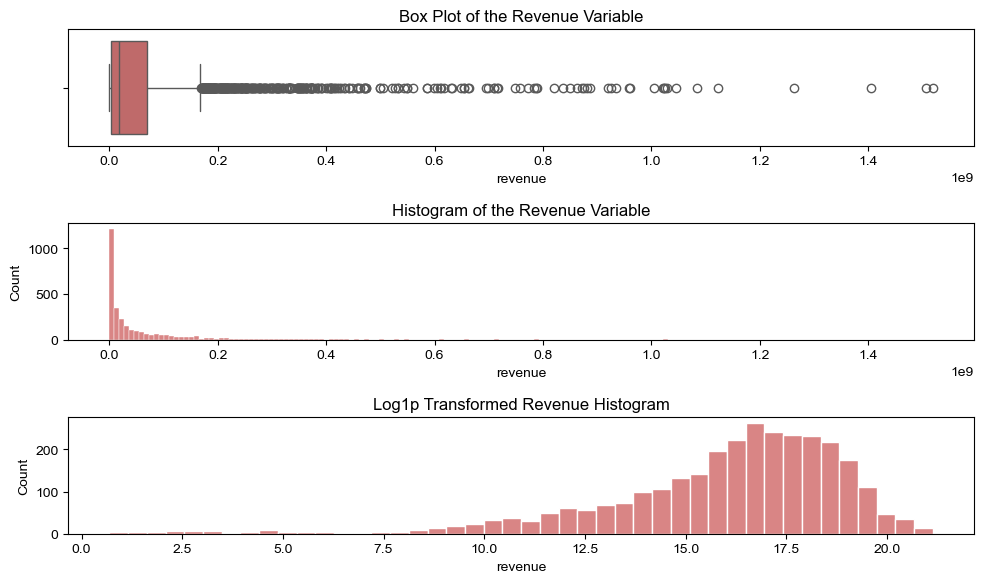

In [22]:
f, ax = plt.subplots(3, figsize=(10,6))

sns.set(rc={'figure.figsize':(12,8)})
sns.boxplot(x=train.revenue, ax=ax[0], color='indianred')
ax[0].set_title("Box Plot of the Revenue Variable")
sns.histplot(train.revenue, kde=False, ax=ax[1], color='indianred')
ax[1].set_title("Histogram of the Revenue Variable")
sns.histplot(np.log1p(train.revenue), kde=False, ax=ax[2], color='indianred')
ax[2].set_title("Log1p Transformed Revenue Histogram")

f.tight_layout()

In [23]:
# Retrieving and printing the 20 smallest revenue values in the dataset
smallest_revenues = train.revenue.nsmallest(20)
print(smallest_revenues)

347      1
1754     1
1874     1
1917     1
695      2
334      3
1541     3
2383     3
2117     4
1346     5
2490     6
1190     7
639      8
2251     8
2582     8
280     10
665     10
1141    11
312     12
450     12
Name: revenue, dtype: int64


It is evident that there are several extremely low and unrealistic values in the revenue column. This is an issue we may need to address later, and we will revisit it after inspecting the rest of the dataset.


In [25]:
# Adding the 'revenue' column to the list of features to be log-transformed
log_features.append("revenue")

When examining the target variable, we notice that the revenue distribution is heavily skewed to the right. This is expected, as the average movie earns close to $67 million, but a significant number of films make hundreds of millions, especially major box office hits. These high-grossing releases skew the revenue data considerably. Applying a log transformation makes the distribution much more manageable and helps reduce this skew.


### Belongs to Collection
This column indicates whether a film is part of a collection, meaning it belongs to a series of movies rather than being a standalone film. If a movie is part of a collection, the column contains the collection name as a string; otherwise, it is marked as NA. To simplify our analysis, we will modify this column to represent 1 if a movie is in a collection and 0 if it is not.

In [28]:
# Converting the 'belongs_to_collection' column to binary:
# 1 if the movie belongs to a collection (i.e., the value is a string),
# 0 if it does not (i.e., the value is NA).
train.belongs_to_collection = train.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)
test.belongs_to_collection = test.belongs_to_collection.apply(lambda x: 1 if type(x) == str else 0)

In [29]:
# Printing the count of movies that belong to a collection (1) versus those that do not (0)
print(train.belongs_to_collection.value_counts())

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64


The majority of movies are standalone, which is expected, even though there are many well-known film series. Most films are not part of a collection.


### Univariate Analysis

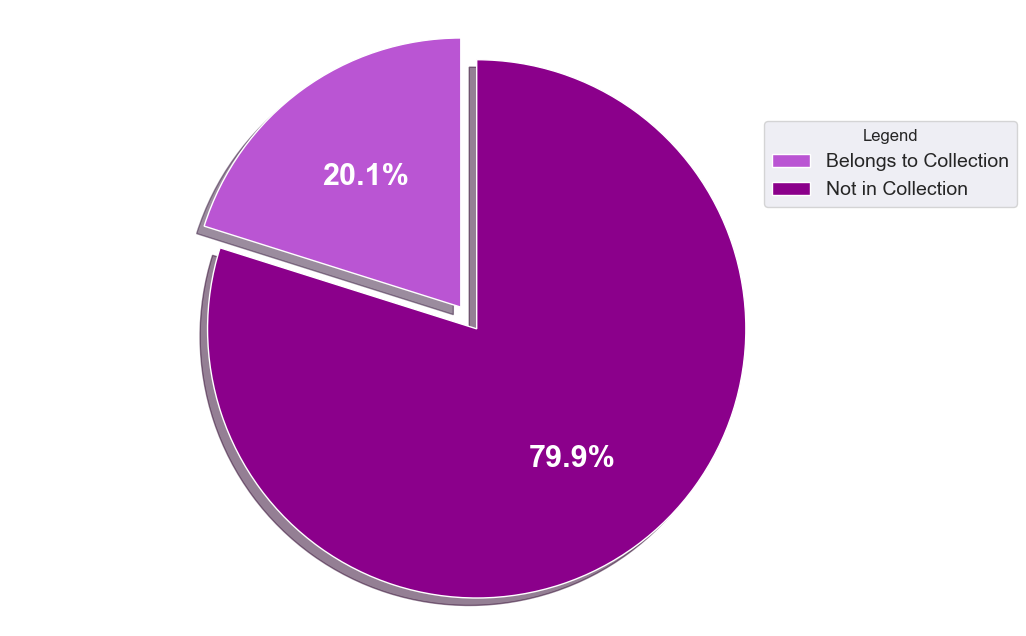

In [32]:
# Plotting data for movies that belong to a collection vs. standalone movies
labels = 'Belongs to Collection', 'Not in Collection'  # Labels for the pie chart
btc_1 = [sum(train.belongs_to_collection), (train.belongs_to_collection == 0).sum(axis=0)]  # Data for the pie chart
explode = (0.1, 0)  # Emphasize the first slice for movies part of a collection

colors = ['mediumorchid', 'darkmagenta']  # Colors for the slices

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, 
       colors=colors, textprops={'color':"w", 'fontsize': 22, 'weight':"bold"})  # Adding text style and format
ax.axis('equal')  # Ensures the chart is a perfect circle

# Adding a legend to the pie chart
ax.legend(labels,
          title="Legend",
          loc="center left",  # Position of the legend
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))  # Bounding box for the legend


Out of 3,000 data points, 604 movies (20.1%) were part of a film collection, while the remaining 2,396 movies (79.9%) were standalone. Being part of a collection could be a significant factor in predicting revenue, as audiences might be more inclined to pay for the next installment in a series they are already invested in. The concept of serialized media dates back to 1836 with Charles Dickens' *The Pickwick Papers*, and it has grown in popularity ever since, continuing strongly into the 21st century. Given the enduring appeal of serial storytelling, it is hypothesized that movies belonging to a collection will show a positive correlation with higher revenue.


In [34]:
train.isna().sum()

id                          0
belongs_to_collection       0
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

### Bivariate Analysis

belongs_to_collection
0    2396
1     604
Name: count, dtype: int64


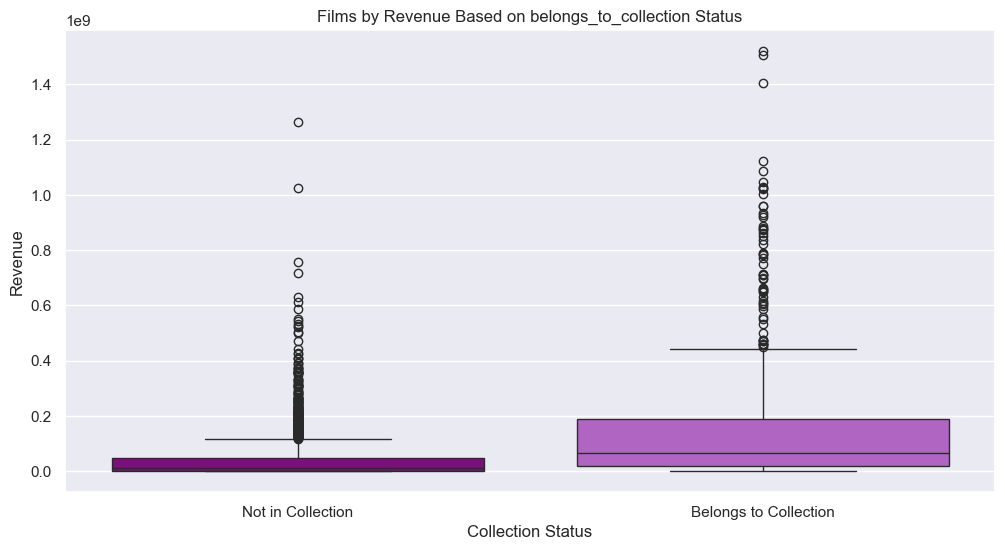

In [36]:
# Bivariate analysis of revenue with belongs_to_collection
print(train['belongs_to_collection'].value_counts())

# Labels for the x-axis categories
labels = 'Not in Collection', 'Belongs to Collection'

# Custom color palette for the boxplot
pal1 = ['darkmagenta', 'mediumorchid']

# Creating a boxplot to compare revenue based on collection status
fig, ax = plt.subplots(figsize=(12, 6))  # Setting the figure size
sns.boxplot(x='belongs_to_collection', y='revenue', data=train, hue='belongs_to_collection', palette=pal1, legend=False)  # Using hue and removing legend

plt.title('Films by Revenue Based on belongs_to_collection Status')  # Title of the plot
plt.ylabel("Revenue")  # Label for the y-axis
plt.xlabel("Collection Status")  # Label for the x-axis

# Setting custom x-axis tick labels to show 'Not in Collection' and 'Belongs to Collection'
ax.set_xticks([0, 1])
ax.set_xticklabels(labels)

plt.show()

The graph above supports the hypothesis that being part of a collection positively correlates with higher film revenue. Further analysis could be conducted to quantify the exact benefit of a film's 'Belongs in Collection' status.


In [38]:
train_features.append('belongs_to_collection')

In [39]:
# Analyzing correlation between belongs_to_collection and revenue
corr, _ = pearsonr(train['belongs_to_collection'], train['revenue'])
print('Pearson\'s correlation between belongs_to_collection and revenue: %.3f' % corr)

# Analyzing correlation between belongs_to_collection and log-transformed revenue
corr, _ = pearsonr(train['belongs_to_collection'], np.log1p(train['revenue']))
print('Pearson\'s correlation between belongs_to_collection and the log-transformed revenue: %.3f' % corr)

Pearson's correlation between belongs_to_collection and revenue: 0.339
Pearson's correlation between belongs_to_collection and the log-transformed revenue: 0.257


As hypothesized, there is a small positive correlation between a film belonging to a collection and its revenue.


### Budget
The budget column represents the estimated income and expenditure for a film. Intuitively, this seems like an important variable for predicting revenue, as higher-budget films often have higher production values and are expected to achieve greater success. However, this is not always the case, and it warrants further investigation.


### Univariate Analysis

In [43]:
# Printing the number of movies with missing budget values
print('Movies missing a budget:', train.budget.isna().sum())

Movies missing a budget: 0


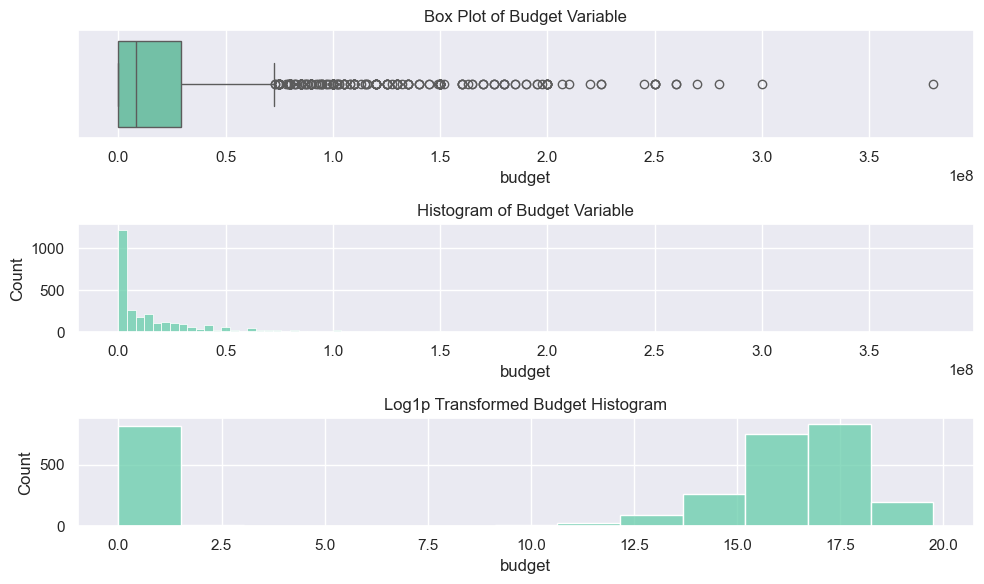

In [44]:
# Plotting the budget data
f, ax = plt.subplots(3, figsize=(10,6))  # Creating subplots for the three visualizations

sns.set(rc={'figure.figsize':(12,8)})  # Setting figure size for Seaborn plots

# Box plot for the budget variable
sns.boxplot(x=train.budget, ax=ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of Budget Variable")

# Histogram of the budget variable
sns.histplot(train.budget, kde=False, ax=ax[1], color='mediumaquamarine')
ax[1].set_title("Histogram of Budget Variable")

# Log1p transformed histogram for the budget variable
sns.histplot(np.log1p(train.budget), kde=False, ax=ax[2], color='mediumaquamarine')
ax[2].set_title("Log1p Transformed Budget Histogram")

# Adjusting layout for better visualization
f.tight_layout()


In [45]:
# Printing the number of movies with a budget listed as 0
print('Movies with budget listed as 0: ', (train.budget == 0).sum())

Movies with budget listed as 0:  812


The distribution of the budget in the training set is also heavily skewed to the right, much like the revenue. Therefore, we examine the log-transformed distribution as well. While no movies are missing a budget, there are over 800 movies in the training set with a budget listed as 0. This is highly unlikely, as all produced films have some form of budget. It's probable that these 0 values were used as placeholders when the actual budget data was unavailable. To clean the data, we will replace these 0 values with the median budget to help reduce the skew.


In [47]:
# Calculating the median budget for movies that have a budget greater than 0
median = train.loc[train['budget'] > 0, 'budget'].median()

# Replacing budget values of 0 with the median budget in the training set
train["budget_processed"] = train["budget"].mask(train["budget"] == 0, median)

# Replacing budget values of 0 with the median budget in the test set
test["budget_processed"] = test["budget"].mask(test["budget"] == 0, median)

In [48]:
# Retrieving the 10 smallest values from the 'budget_processed' column in the training set
train.nsmallest(10, 'budget_processed')['budget_processed']

334     1
695     1
849     1
1346    1
2255    1
1754    2
2032    4
1198    5
1800    5
639     6
Name: budget_processed, dtype: int64

There appear to be several unrealistic budget values beyond just those listed as 0. To address this, we will replace all budget values below 10,000 USD, as this seems to be a reasonable minimum threshold. No major feature film is realistically produced for under 10,000 USD. Even one of the most famous examples of a low-budget success, *The Blair Witch Project*, had a budget of 40,000 USD.


In [50]:
median = train.loc[train['budget'] >= 10000, 'budget'].median()
train["budget_processed"] = train["budget"].mask(train["budget"] < 10000, median)
test["budget_processed"] = test["budget"].mask(test["budget"] < 10000, median)

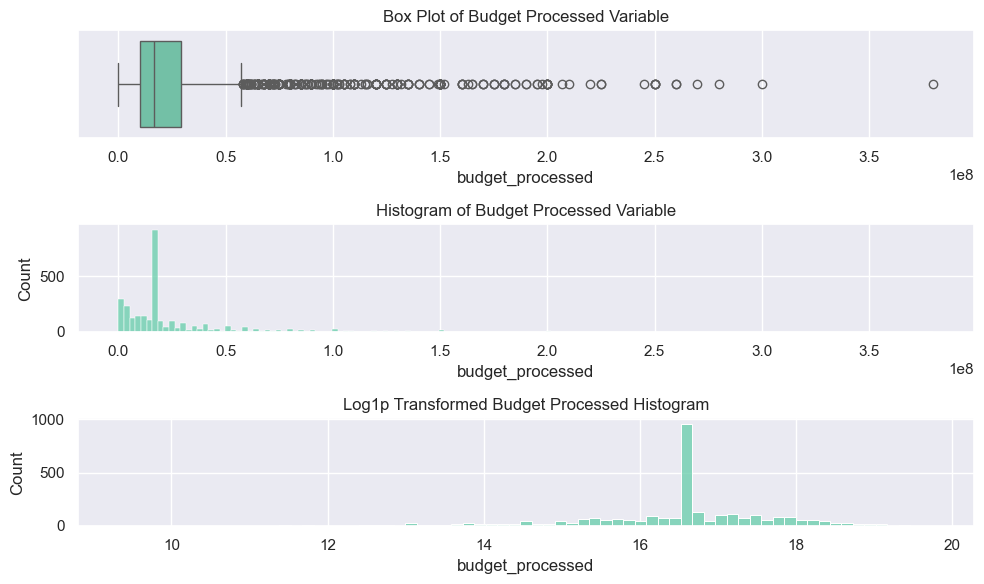

In [51]:
# Plotting the processed budget data
f, ax = plt.subplots(3, figsize=(10,6))  # Creating subplots for different visualizations

sns.set(rc={'figure.figsize':(12,8)})  # Setting figure size for Seaborn plots

# Box plot for the processed budget variable
sns.boxplot(x=train.budget_processed, ax=ax[0], color='mediumaquamarine')
ax[0].set_title("Box Plot of Budget Processed Variable")

# Histogram of the processed budget variable
sns.histplot(train.budget_processed, kde=False, ax=ax[1], color='mediumaquamarine')
ax[1].set_title("Histogram of Budget Processed Variable")

# Log1p transformed histogram for the processed budget variable
sns.histplot(np.log1p(train.budget_processed), kde=False, ax=ax[2], color='mediumaquamarine')
ax[2].set_title("Log1p Transformed Budget Processed Histogram")

# Adjusting layout for better visualization
f.tight_layout()


Since many values in the budget column were below 10,000, replacing them with the median has created a large cluster of data around this value. This distribution is still not ideal, so we will look for a more suitable method to replace these values in the future.


### Bivariate Analysis

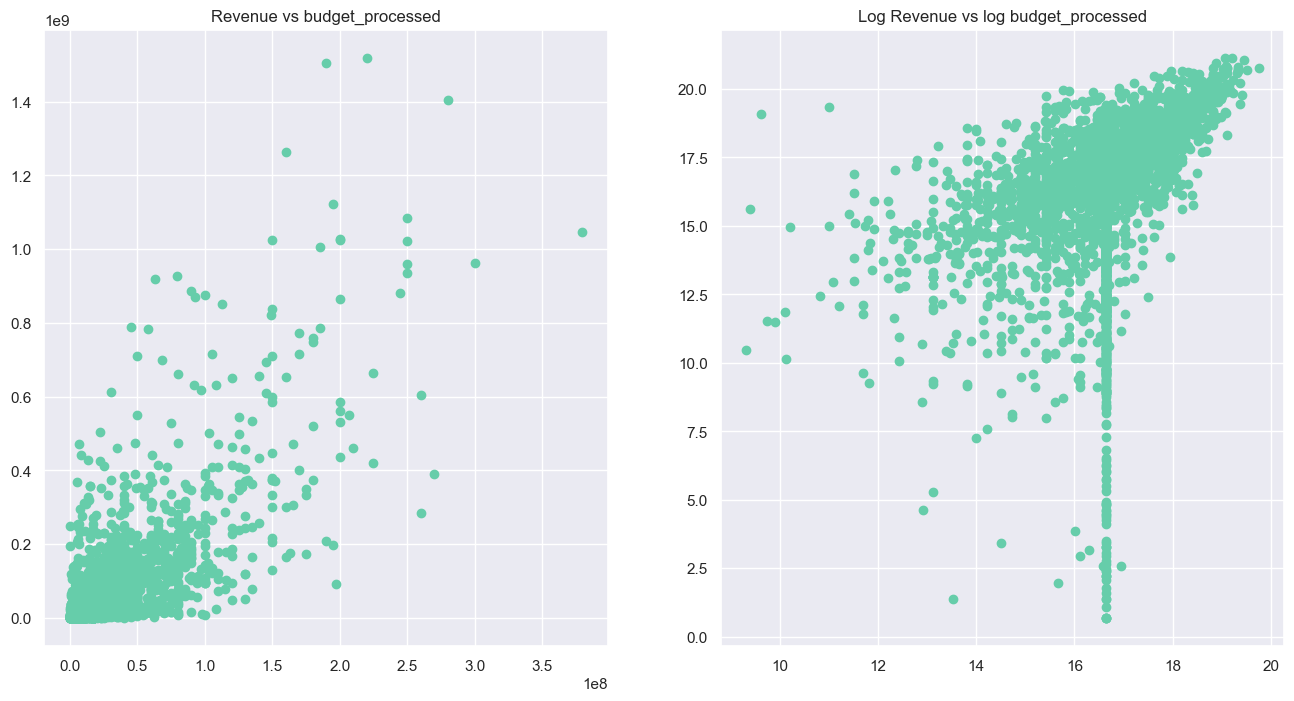

In [54]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['budget_processed'], train['revenue'], color='mediumaquamarine')
plt.title('Revenue vs budget_processed');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['budget_processed']), np.log1p(train['revenue']), color='mediumaquamarine')
plt.title('Log Revenue vs log budget_processed');

In [55]:
# Adding 'budget_processed' to the list of features to be log-transformed
log_features.append('budget_processed')

In [56]:
#analysis of correlation and create log feature probably
corr, _ = pearsonr(train['budget_processed'], train['revenue'])
print('Pearsons correlation between budget_processed and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['budget_processed']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed transformed budget_processed and log transformed revenue: %.3f' % corr)

Pearsons correlation between budget_processed and revenue: 0.746
Pearsons correlation between log transformed transformed budget_processed and log transformed revenue: 0.373


The analysis shows a fairly strong correlation between the budget and revenue variables.


### Genres
The genres column represents the genre(s) of a film. Since different genres may perform differently at the box office, this is an interesting variable to explore to determine if there is any relationship to revenue.


In [59]:
train['genres'].head()

0                       [{'id': 35, 'name': 'Comedy'}]
1    [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
2                        [{'id': 18, 'name': 'Drama'}]
3    [{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...
4    [{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...
Name: genres, dtype: object

In [60]:
# Printing the number of movies with missing genre information
print("Movies missing genres: ", train['genres'].isna().sum())

Movies missing genres:  7


The genres column contains a lot of unnecessary information, making it difficult to work with. To address this, we will preprocess the data by using a regular expression to extract only the genre names and store them in a new column as a list for each film. Additionally, we will fill any missing values (NA) with a blank string.


### Pre-processing

In [63]:
# Filling missing values in the 'genres' column with an empty string
train['genres'] = train['genres'].fillna('')

# Extracting genre names using a regular expression and creating a new column 'genres_reform'
train['genres_reform'] = train['genres'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))

# Applying the same preprocessing to the test dataset
test['genres'] = test['genres'].fillna('')

# Extracting genre names in the test dataset and storing in 'genres_reform'
test['genres_reform'] = test['genres'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))


With the list of genres for each film now available, we will unpack all the genres into a new DataFrame to facilitate easier exploration and analysis. While this study does not delve into it, an intriguing direction for future research could be examining the temporal trends in genre popularity. Different genres may attract varying levels of interest from moviegoers across different historical film periods.


In [65]:
# Function to unpack all of the different genres into unique columns
def unpackCol(genre_list, df):
    for i in range(len(df)):
        for name in genre_list[i]:
            if name not in df.columns:
                df[name] = 0
            df.loc[i, name] = 1  # Use .loc to avoid the chained assignment warning
    return df

In [66]:
# Creating an empty DataFrame and unpacking genres into unique columns from 'genres_reform'
df = pd.DataFrame()
df = unpackCol(train['genres_reform'], train)  # Unpacking genres into separate columns

# Printing the column names to verify the unique genre columns
print(df.columns)

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew', 'revenue',
       'budget_processed', 'genres_reform', 'Comedy', 'Drama', 'Family',
       'Romance', 'Thriller', 'Action', 'Animation', 'Adventure', 'Horror',
       'Documentary', 'Music', 'Crime', 'Science Fiction', 'Mystery',
       'Foreign', 'Fantasy', 'War', 'Western', 'History', 'TV Movie'],
      dtype='object')


In [67]:
# Creating a new feature that counts the number of genres for each film
train['num_genres'] = train.genres_reform.apply(lambda x: len(x))
test['num_genres'] = test.genres_reform.apply(lambda x: len(x))

# Displaying the count of films by the number of genres they belong to
train['num_genres'].value_counts()

num_genres
2    972
3    900
1    593
4    393
5    111
6     21
0      7
7      3
Name: count, dtype: int64

We create a new column that counts the number of genres listed for each movie. This may be interesting to explore further to see if there is any correlation between the number of genres and revenue.


### Univariate Analysis

Text(0.5, 0, 'Genre')

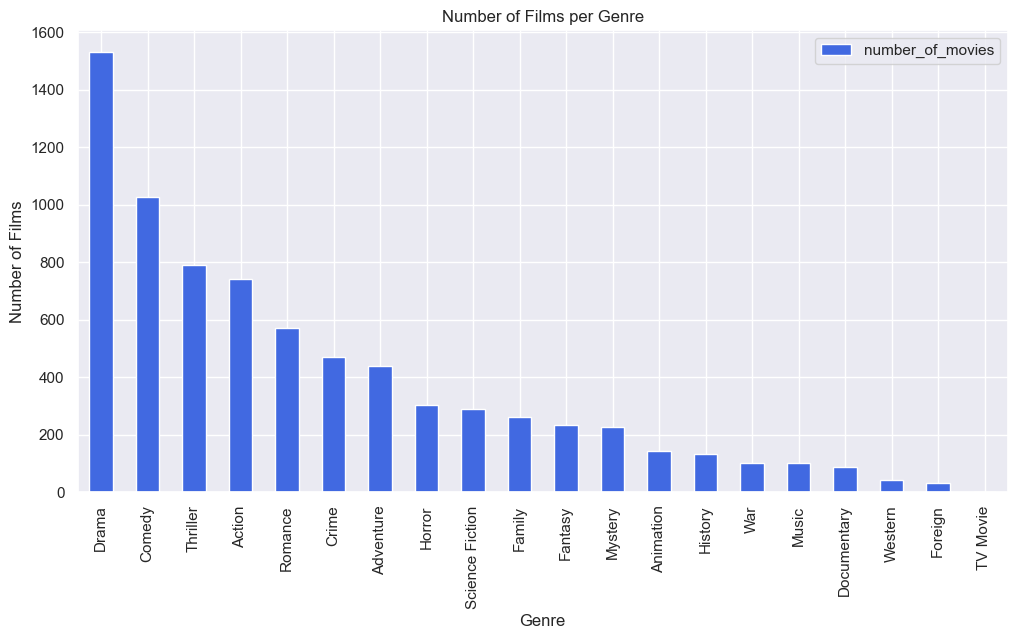

In [70]:
# Creating a dictionary to count the number of instances of each genre
genresDict = dict()

# Iterating through the 'genres_reform' column to count each genre
for genre in df["genres_reform"]:
    for elem in genre:
        if elem not in genresDict:
            genresDict[elem] = 1  # Initialize the genre count if it's not in the dictionary
        else:
            genresDict[elem] += 1  # Increment the count for the genre

# Setting figure size for the plot
sns.set(rc={'figure.figsize':(12,6)})

# Converting the genre dictionary into a DataFrame for easier plotting
genres_df = pd.DataFrame.from_dict(genresDict, orient='index')
genres_df.columns = ["number_of_movies"]  # Renaming the column
genres_df = genres_df.sort_values(by="number_of_movies", ascending=False)  # Sorting genres by the number of movies

# Plotting the number of films per genre as a bar chart
genres_df.plot.bar(color='royalblue')

# Adding plot labels and title
plt.title("Number of Films per Genre")
plt.ylabel("Number of Films")
plt.xlabel("Genre")


Genres of movies often follow specific trends in popularity, such as the recent surge in superhero films that began in the 1990s with 20th Century Fox's *X-Men* series. While superhero movies have existed since at least 1978 with Richard Donner's *Superman*, the latest trend has had a defining impact on the film industry over the past two decades. For the purposes of this report, superhero films are categorized under Action/Adventure (and Fantasy), though these genres also include other popular subgenres.

Action and Adventure films have a relatively high number of releases, leading to the hypothesis that more common genres may also be more popular and thus generate higher revenues. As a result, Drama, Comedy, and Thriller films may be expected to show the highest revenues. However, the role of genre in determining a film's revenue (and predicting future success) is significant, especially given the often unpredictable nature of audience preferences.


In [72]:
# List of film genres by the number of films in each genre, sorted by order of count
genres = [
    'Drama', 'Comedy', 'Thriller', 'Action', 'Romance', 'Crime', 
    'Adventure', 'Horror', 'Science Fiction', 'Family', 'Fantasy', 
    'Mystery', 'Animation', 'History', 'War', 'Music', 'Documentary', 
    'Western', 'Foreign', 'TV Movie'
]

# Printing the sum of films for each genre
for genre in genres:
    print(f"{genre}: {df[genre].sum()}")

Drama: 1531
Comedy: 1028
Thriller: 789
Action: 741
Romance: 571
Crime: 469
Adventure: 439
Horror: 301
Science Fiction: 290
Family: 260
Fantasy: 232
Mystery: 225
Animation: 141
History: 132
War: 100
Music: 100
Documentary: 87
Western: 43
Foreign: 31
TV Movie: 1


In terms of genres, we observe a nearly logarithmic distribution, with Drama (1531 films) being the most common and TV Movies (1 film) being the least. For the purposes of this analysis, we assume that this dataset is representative of broader trends in filmography. Typically, we might expect more popular genres to correlate with higher revenues due to their widespread appeal. However, it's important to also consider the unique draw of films in "rare genres." For example, *La La Land*, a musical, grossed `$446.1 million` at the box office with a modest `$30 million` budget. Therefore, the potential for outliers or even inverse trends in genre popularity and revenue warrants further exploration.



### Bivariate Analysis

In [75]:
# Bivariate analysis of revenue with genre

# Getting the index values (genre names) from the genres DataFrame
genres_df.index.values

# Creating binary columns for each genre in the df dataset (1 if the movie belongs to that genre, 0 if not)
for g in genres_df.index.values:
    df[g] = df['genres_reform'].apply(lambda x: 1 if g in x else 0)

# Calculating the median revenue per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "median_rev"] = df[df[g] == 1].revenue.median()  # Median revenue for movies of each genre

# Sorting the genres by number of movies and median revenue, and displaying the top 10
genres_df.sort_values(by=["number_of_movies", "median_rev"], ascending=False).head(10)

# Calculating the mean revenue per genre type
for i, g in enumerate(genres_df.index.values):
    genres_df.loc[g, "mean_rev"] = df[df[g] == 1].revenue.mean()  # Mean revenue for movies of each genre

# Sorting the genres by number of movies and mean revenue, and displaying the top 10
genres_df.sort_values(by=["number_of_movies", "mean_rev"], ascending=False).head(10)

,number_of_movies,median_rev,mean_rev
Drama,1531,11293663.0,4.540607e+07
Comedy,1028,18809184.0,6.087574e+07
Thriller,789,21890845.0,6.833664e+07
Action,741,36000000.0,1.110434e+08
Romance,571,14016568.0,5.270501e+07
Crime,469,24048000.0,5.949128e+07
Adventure,439,59700000.0,1.758095e+08
Horror,301,17037887.0,5.270907e+07
Science Fiction,290,35109301.5,1.223672e+08
Family,260,57470029.5,1.388978e+08


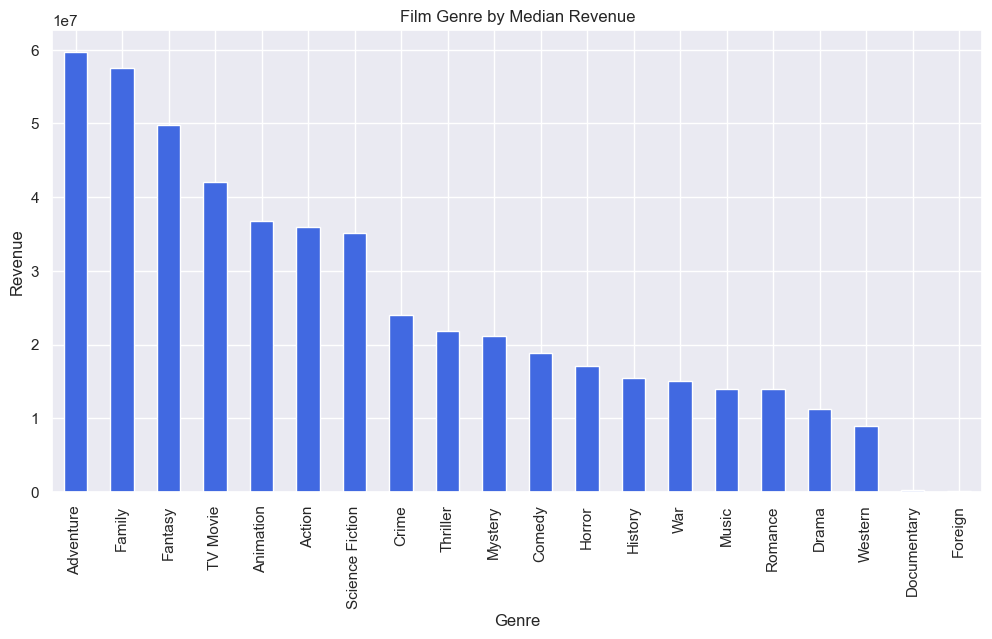

In [76]:
# Plotting genres by median revenue
genres_df.sort_values(by=["median_rev"], ascending=False).median_rev.plot.bar(color='royalblue')

# Adding title and labels to the plot
plt.title("Film Genre by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

# Displaying the plot
plt.show()

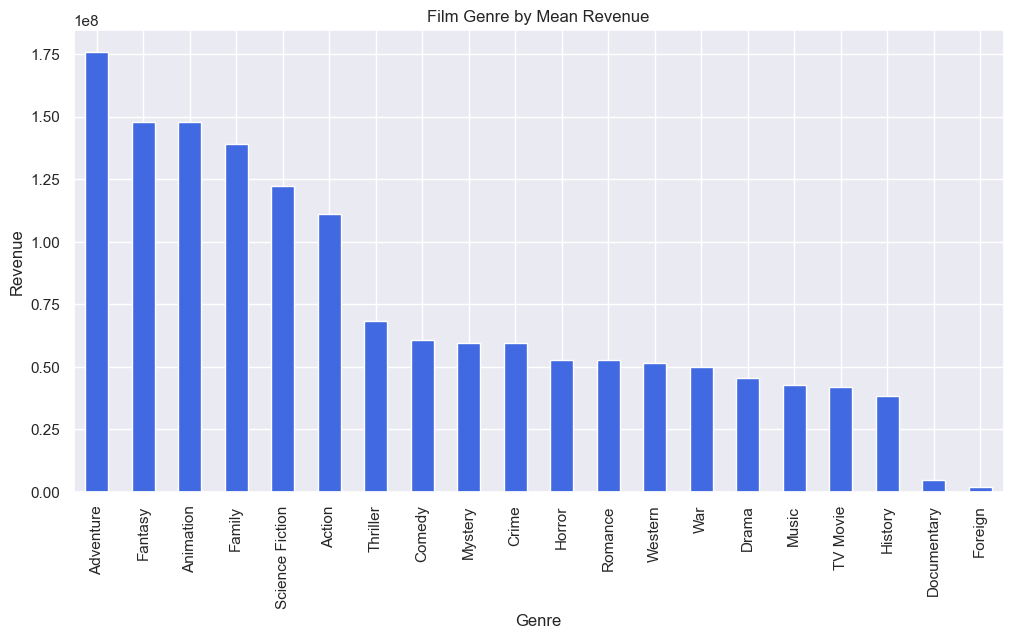

In [77]:
# Plotting genres by mean revenue
genres_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.plot.bar(color='royalblue')

# Adding title and labels to the plot
plt.title("Film Genre by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Genre")

# Displaying the plot
plt.show()

In both the 'Film Genre by Median Revenue' and 'Film Genre by Mean Revenue' plots, Adventure films have the highest revenue values, with the ordering being fairly consistent between the two, except for a few notable changes. For instance, using `median_rev`, the TV Movie genre ranks fourth in terms of revenue, but using `mean_rev` drops it to fourth lowest. Similarly, History drops five places from `median_rev` to `mean_rev`, while Comedy rises by three spots.

Although some common film genres (those with a higher number of films in the training data) perform well in terms of revenue, the initial hypothesis that a genre’s popularity would correlate positively with revenue is disproven by the relatively lower revenues for Dramas, Comedies, and Thrillers—the three most common genres in the dataset. This could be due to saturated demand in these genres or other unrelated factors. What is clear is that Adventure, Family, Fantasy, and Animation genres consistently rank high in both median and mean revenue.


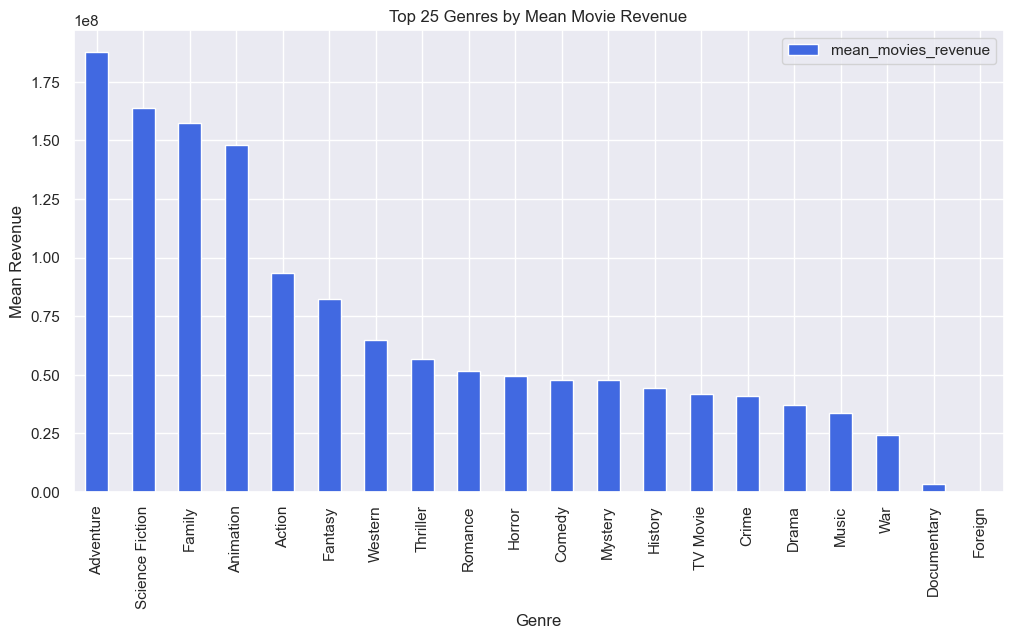

In [79]:
# Creating a dictionary to store total revenue and count for each top genre
topGenreDict = {}

# Iterating through the 'revenue' and 'genres_reform' columns in the train dataset
for element in train[["revenue", "genres_reform"]].values:
    temp = 1  # Set temp to compare results for top genre (1st genre in the list)
    
    # If the movie has fewer genres than 'temp', adjust 'temp' to the length of the genre list
    if len(element[1]) < temp:
        temp = len(element[1])
    
    # Iterating through the top 'temp' genres for each movie
    for i in range(temp):
        if element[1][i] not in topGenreDict:
            # If the genre is not already in the dictionary, add it with revenue and count
            topGenreDict[element[1][i]] = [element[0], 1]
        else:
            # If the genre is already in the dictionary, update the total revenue and count
            topGenreDict[element[1][i]][0] += element[0]
            topGenreDict[element[1][i]][1] += 1

# Calculating the mean revenue for each genre
for genre in topGenreDict:
    topGenreDict[genre][0] = topGenreDict[genre][0] / topGenreDict[genre][1]  # Mean revenue
    topGenreDict[genre] = topGenreDict[genre][0]  # Store only the mean revenue in the dictionary

# Converting the dictionary into a DataFrame for easier manipulation and visualization
genres_df = pd.DataFrame.from_dict(topGenreDict, orient='index', columns=["mean_movies_revenue"])

# Sorting the DataFrame by mean revenue and plotting the top 25 genres as a bar chart
genres_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='royalblue')

# Displaying the plot
plt.title("Top 25 Genres by Mean Movie Revenue")
plt.xlabel("Genre")
plt.ylabel("Mean Revenue")
plt.show()

In [80]:
# Sorting the topGenreDict in ascending order of mean revenue
# This allows us to easily access the least successful genres first
topGenreDict = {k: v for k, v in sorted(topGenreDict.items(), key=lambda item: item[1], reverse=False)}

# Sorting the genresDict in descending order of number of films
# This allows us to easily access the most common genres first
genresDict = {k: v for k, v in sorted(genresDict.items(), key=lambda item: item[1], reverse=True)}

# Printing the sorted dictionaries
print("Top Genres by Mean Revenue (Least to Most Successful):")
print(topGenreDict)

print("\nGenres by Number of Films (Most to Least Common):")
print(genresDict)

Top Genres by Mean Revenue (Least to Most Successful):
{'Foreign': 140650.0, 'Documentary': 3538249.971830986, 'War': 24388514.85, 'Music': 33890384.55, 'Drama': 37298750.1133758, 'Crime': 40820052.02040816, 'TV Movie': 42000000.0, 'History': 44237822.875, 'Mystery': 47674838.90909091, 'Comedy': 47754836.36092715, 'Horror': 49586852.62352941, 'Romance': 51648567.82089552, 'Thriller': 56574423.54310345, 'Western': 64905713.538461536, 'Fantasy': 82345105.41176471, 'Action': 93596599.80576923, 'Animation': 148089684.90789473, 'Family': 157347482.6111111, 'Science Fiction': 163833801.36585367, 'Adventure': 187715537.32085562}

Genres by Number of Films (Most to Least Common):
{'Drama': 1531, 'Comedy': 1028, 'Thriller': 789, 'Action': 741, 'Romance': 571, 'Crime': 469, 'Adventure': 439, 'Horror': 301, 'Science Fiction': 290, 'Family': 260, 'Fantasy': 232, 'Mystery': 225, 'Animation': 141, 'History': 132, 'Music': 100, 'War': 100, 'Documentary': 87, 'Western': 43, 'Foreign': 31, 'TV Movie': 

In [81]:
# Function to calculate the average rank of genres based on topGenreDict
def getGenreRank(genres):
    sum = 0  # Initialize sum for accumulating genre ranks
    
    # Iterate through each genre in the given list of genres
    for g in genres:
        # Add the rank (index) of the genre from topGenreDict's keys to the sum
        sum += list(topGenreDict.keys()).index(g)
    
    # Return the average rank of the genres
    return sum / len(genres)

In [82]:
# Applying the getGenreRank function to calculate genre rank for each movie in the training set
# If a movie has no genres, it assigns a rank of 0
train['genre_rank'] = train['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)

# Applying the same logic to the test set
test['genre_rank'] = test['genres_reform'].apply(lambda x: getGenreRank(x) if len(x) > 0 else 0)

# Displaying the frequency of each genre rank in the training set
train['genre_rank'].value_counts()

genre_rank
9.000000     273
4.000000     270
8.000000     229
10.000000    216
7.500000     132
            ... 
9.833333       1
7.600000       1
9.200000       1
16.600000      1
2.666667       1
Name: count, Length: 132, dtype: int64

Using the dictionary of top genres (ranked by revenue), we create an effective ranking system that will serve as a feature for our model. In this system, the higher the genre ranking of a film (based on the average of all its listed genres), the less revenue that genre tends to generate.

In [84]:
# Adding 'genre_rank' and 'num_genres' to the list of features to be log-transformed
log_features.append('genre_rank')
log_features.append('num_genres')

# Analysis of correlation between genre_rank and revenue
# Calculating Pearson's correlation between genre_rank and revenue
corr, _ = pearsonr(train['genre_rank'], train['revenue'])
print('Pearson\'s correlation between genre_rank and revenue: %.3f' % corr)

# Calculating Pearson's correlation between log-transformed genre_rank and log-transformed revenue
corr, _ = pearsonr(np.log1p(train['genre_rank']), np.log1p(train['revenue']))
print('Pearson\'s correlation between log-transformed genre_rank and log-transformed revenue: %.3f' % corr)

Pearson's correlation between genre_rank and revenue: 0.324
Pearson's correlation between log-transformed genre_rank and log-transformed revenue: 0.303


In [85]:
# Analysis of correlation between num_genres and revenue
# Calculating Pearson's correlation between num_genres and revenue
corr, _ = pearsonr(train['num_genres'], train['revenue'])
print('Pearson\'s correlation between num_genres and revenue: %.3f' % corr)

# Calculating Pearson's correlation between log-transformed num_genres and log-transformed revenue
corr, _ = pearsonr(np.log1p(train['num_genres']), np.log1p(train['revenue']))
print('Pearson\'s correlation between log-transformed num_genres and log-transformed revenue: %.3f' % corr)

Pearson's correlation between num_genres and revenue: 0.164
Pearson's correlation between log-transformed num_genres and log-transformed revenue: 0.191


We observe a small positive correlation between our created genre ranking and revenue, indicating that films with higher-ranked genres tend to generate more revenue. In contrast, the correlation between the number of genres and revenue is weaker, suggesting that the variety of genres in a film has less impact on its revenue.

### Homepage

The homepage column contains the website link for a film, if available. This variable is noteworthy as it may indicate that more popular films tend to have dedicated websites. Furthermore, having a homepage could enhance a movie's visibility and contribute to its success at the box office.

### Univariate Analysis

In [89]:
# Check for missing values in the homepage column
print('Movies missing a homepage:', train.homepage.isna().sum())

Movies missing a homepage: 2054


Since each film's homepage is unique and specific, it does not provide significant value for our analysis. Therefore, we will not examine the homepage content for this project. Instead, we will create a new column that indicates whether a movie has a homepage or not. This approach will help streamline our dataset and focus on more relevant features that could influence a film's success.

In [91]:
#Creating new column
train['has_homepage'] = train.homepage.apply(lambda x: 0 if pd.isnull(x) else 1)
test['has_homepage'] = test.homepage.apply(lambda x: 0 if pd.isnull(x) else 1)
train['has_homepage'].value_counts()

has_homepage
0    2054
1     946
Name: count, dtype: int64

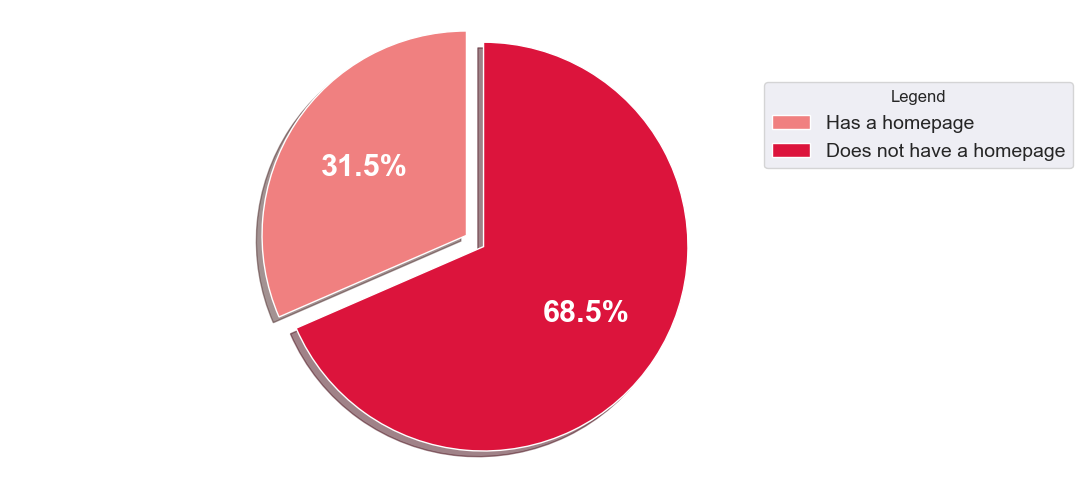

In [92]:
# Plotting the distribution of movies with and without a homepage
labels = 'Has a homepage', 'Does not have a homepage'

# Count the number of movies with and without a homepage
btc_1 = [sum(train.has_homepage), (train.has_homepage == 0).sum(axis=0)]
explode = (0.1, 0)  # Highlight the 'Has a homepage' section

colors = ['lightcoral', 'crimson']  # Define colors for the pie chart

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(btc_1, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90, colors=colors,
       textprops={'color': "w", 'fontsize': 22, 'weight': "bold"})
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

# Add a legend
ax.legend(labels,
          title="Legend",
          loc="center left",
          fontsize=14,
          bbox_to_anchor=(0.8, 0.25, 0.5, 1))

plt.show()  # Display the plot

In the training set of 3,000 data points, 2,054 (68.5%) lack a homepage, while 946 (31.5%) have one. The presence of a homepage may correlate with more well-known or higher-budget films. However, it's important to note that some films could have a homepage that is simply not recorded in the dataset, making it impossible to distinguish between truly missing data and those without a homepage, as both are marked as NA.

### Bivariate Analysis

In [95]:
print("Mean revenue for movies with a homepage: %.2f" % train.loc[train['has_homepage'] == 1, "revenue"].mean())
print("Median revenue for movies with a homepage: %.2f" % train.loc[train['has_homepage'] == 1, "revenue"].median())
print()
print("Mean revenue for movies without a homepage: %.2f" % train.loc[train['has_homepage'] == 0, "revenue"].mean())
print("Median revenue for movies without a homepage: %.2f" % train.loc[train['has_homepage'] == 0, "revenue"].median())

Mean revenue for movies with a homepage: 120051698.84
Median revenue for movies with a homepage: 35455217.00

Mean revenue for movies without a homepage: 42165846.43
Median revenue for movies without a homepage: 12328641.50


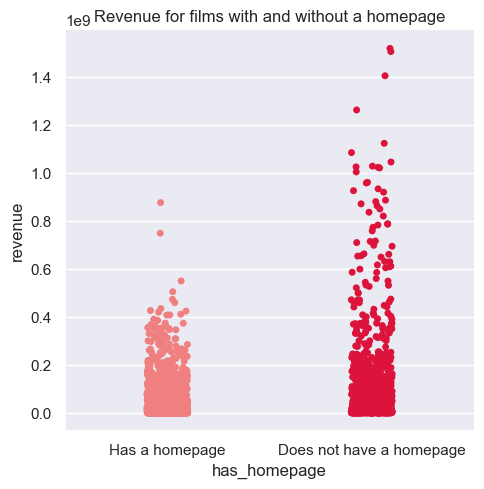

In [96]:
# Define a color palette for the plot
pal1 = ['lightcoral', 'crimson']

# Create a categorical plot showing revenue based on whether a film has a homepage
ax = sns.catplot(x='has_homepage', y='revenue', hue='has_homepage', data=train, palette=pal1, legend=False)

# Set the title for the plot
plt.title('Revenue for films with and without a homepage')

# Define labels for the x-tick marks
labels = 'Has a homepage', 'Does not have a homepage'
ax.set_xticklabels(labels)  # Update the x-tick labels to be more descriptive

In [97]:
train_features.append('has_homepage')

In [98]:

corr, _ = pearsonr(train['has_homepage'], train['revenue'])
print('Pearsons correlation between has_homepage and revenue: %.3f' % corr)
corr, _ = pearsonr(train['has_homepage'], np.log1p(train['revenue']))
print('Pearsons correlation between has_homepage and log transformed revenue: %.3f' % corr)

Pearsons correlation between has_homepage and revenue: 0.263
Pearsons correlation between has_homepage and log transformed revenue: 0.143


There is a slight positive correlation between the presence of a homepage and revenue. The categorical plot indicates that movies without a homepage achieve greater revenues, likely due to the larger number of films in that category. Notably, the mean revenue for films without a homepage is significantly higher; however, this is skewed by outliers. In contrast, the median revenue for movies with a homepage is larger, suggesting that those films may perform better overall.

### Popularity
The popularity column contains a metric indicating the popularity of a movie. However, the exact scale or rating system behind this metric is unclear. We will explore this variable further to gain more insight into its meaning and potential impact on revenue.

### Univariate Analysis

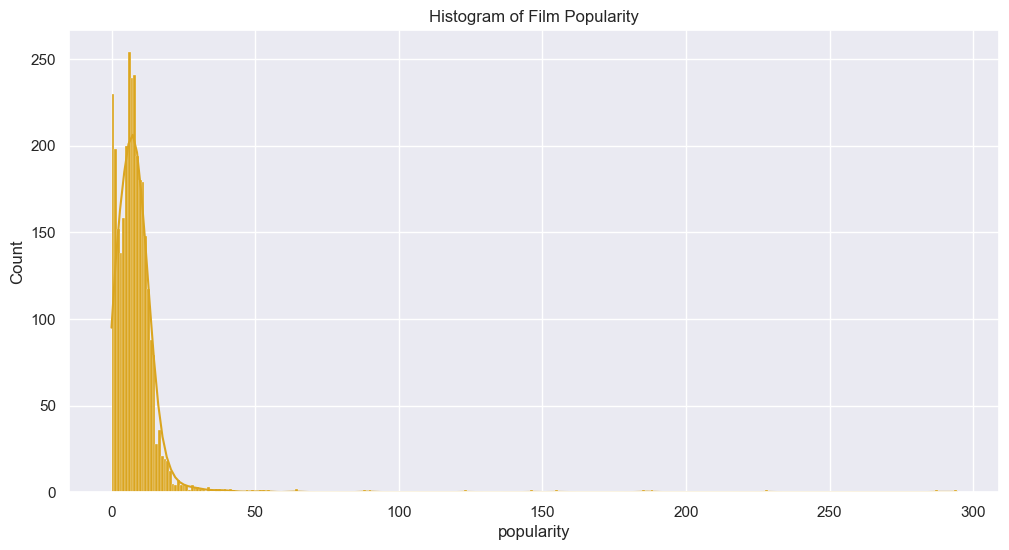

In [102]:
# Plotting the distribution of popularity with a histogram and KDE
sns.histplot(train['popularity'], kde=True, color='goldenrod', alpha=1)

# Setting figure size for the plot
sns.set(rc={'figure.figsize':(12, 2)})

# Adding title to the plot
plt.title('Histogram of Film Popularity')

# Displaying the plot
plt.show()

In [103]:
# Printing the summary statistics for the 'popularity' column
print(train['popularity'].describe())

count    3000.000000
mean        8.463274
std        12.104000
min         0.000001
25%         4.018053
50%         7.374861
75%        10.890983
max       294.337037
Name: popularity, dtype: float64


Popularity is likely to be a significant feature in predicting revenue outcomes, given its potential influence on movie viewership. This, of course, depends on whether the popularity metric refers to the pre-release 'hype' surrounding a film or post-release ratings. If it's the former, popularity should theoretically have a strong positive correlation with revenue, as higher popularity typically leads to better marketing and increased ticket sales. 

From the 3,000 films in the dataset, the average popularity is 8.46, with a minimum of 0.00 and a maximum of 294.34. The histogram shows that most films have a popularity score between 0 and 25, with a few highly popular outliers. These outliers will be addressed later in the analysis.

### Bivariate Analysis

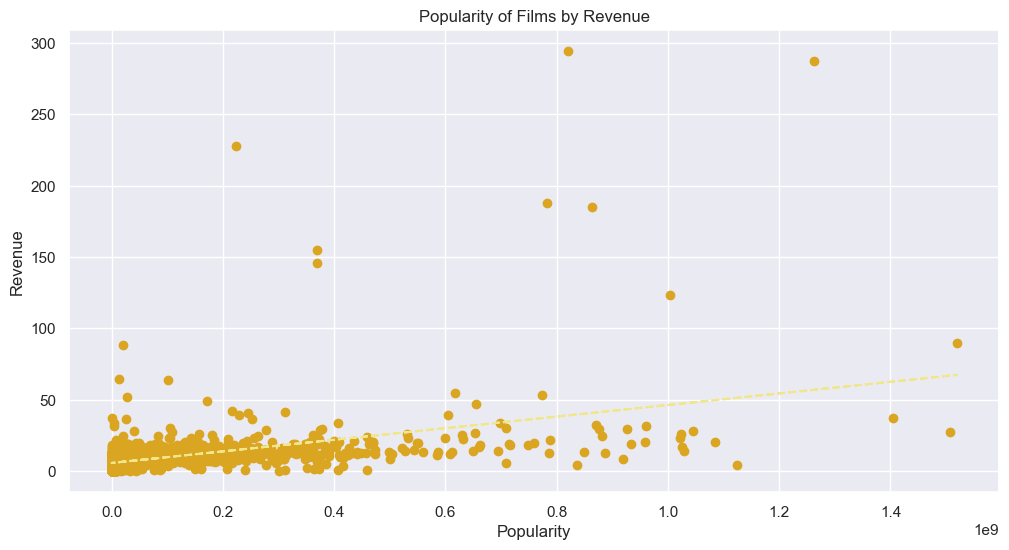

In [106]:
# Bivariate analysis: plotting popularity against revenue
sns.set(rc={'figure.figsize':(12, 6)})  # Setting figure size

# Assigning revenue and popularity to variables
cx = train['revenue']
pop = train['popularity']

# Scatter plot of revenue vs popularity
plt.plot(cx, pop, 'o', color='goldenrod')
plt.ylabel("Revenue")
plt.xlabel("Popularity")
plt.title("Popularity of Films by Revenue")

# Fitting a linear trend line to the scatter plot
z = np.polyfit(cx, pop, 1)  # Linear fit (degree 1 polynomial)
p = np.poly1d(z)  # Create a polynomial object from the fit
plt.plot(cx, p(cx), "--", color='khaki')  # Plotting the trend line
plt.show()  # Display the plot

In [107]:
# Analysis of correlation between popularity and revenue
# Calculating Pearson's correlation between popularity and revenue
corr, _ = pearsonr(train['popularity'], train['revenue'])
print('Pearson\'s correlation between popularity and revenue: %.3f' % corr)

# Calculating Pearson's correlation between log-transformed popularity and log-transformed revenue
corr, _ = pearsonr(np.log1p(train['popularity']), np.log1p(train['revenue']))
print('Pearson\'s correlation between log-transformed popularity and log-transformed revenue: %.3f' % corr)

Pearson's correlation between popularity and revenue: 0.461
Pearson's correlation between log-transformed popularity and log-transformed revenue: 0.542


When comparing popularity to revenue, we observe a general positive correlation. This is expected, as higher popularity can lead to greater viewership and, consequently, increased revenue. However, further investigation into outliers reveals that some highly popular films do not generate significantly higher revenue. This suggests that while popularity is an influential factor, it is not a perfect predictor of a film's monetary success.

Additionally, there is some ambiguity regarding the scale and origin of the popularity metric, particularly in how outliers are handled. More importantly, it seems that popularity can only be assessed after a film's release, making it less useful for studios aiming to predict box office revenue. Instead, popularity may serve better as a label for predicting audience interest or engagement, similar to predicting a movie's rating. For the purposes of this project, the popularity feature will not be included in the final model.

In [109]:
cols_to_drop.append('popularity')

### Production Companies

This column lists all the production companies involved in creating each film. Major studios, given their reputations and resources, can significantly influence a film's revenue. As a result, the involvement of well-known production companies may serve as a strong predictor for the movie’s box office performanc.


In [111]:
# Display the first 10 rows of the 'production_companies' column
print(train['production_companies'].head(10))

0    [{'name': 'Paramount Pictures', 'id': 4}, {'na...
1          [{'name': 'Walt Disney Pictures', 'id': 2}]
2    [{'name': 'Bold Films', 'id': 2266}, {'name': ...
3                                                  NaN
4                                                  NaN
5                                                  NaN
6    [{'name': 'Ghost House Pictures', 'id': 768}, ...
7                                                  NaN
8    [{'name': 'Walt Disney Pictures', 'id': 2}, {'...
9    [{'name': 'Castle Rock Entertainment', 'id': 97}]
Name: production_companies, dtype: object


Much like the genres column, the data in the production companies column is somewhat messy and requires preprocessing to make it more suitable for analysis. We will use a similar approach as with the genres, applying a regular expression to extract the studio names for cleaner data manipulation.

### Pre-processing

In [114]:
# Check for missing values in the 'production_companies' column
train['production_companies'].isna()

0       False
1       False
2       False
3        True
4        True
        ...  
2995    False
2996    False
2997    False
2998    False
2999    False
Name: production_companies, Length: 3000, dtype: bool

In [115]:
# For train dataset
train['production_companies'] = train['production_companies'].fillna('')  # Replace missing values with an empty string
train['production_companies_reform'] = train['production_companies'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))  # Extract studio names

# For test dataset
test['production_companies'] = test['production_companies'].fillna('')  # Replace missing values with an empty string
test['production_companies_reform'] = test['production_companies'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))  # Extract studio names

# For df dataset
df['production_companies'] = df['production_companies'].fillna('')  # Replace missing values with an empty string
df['production_companies_reform'] = df['production_companies'].apply(lambda x: re.findall("'name': \'(.+?)\'", x))  # Extract studio names

The first aspect we will explore after cleaning the data is the number of production studios involved in each film. This could potentially be an interesting feature to include in our model, as the number of studios may have an impact on a film's success.

In [117]:
# Create a new column 'num_studios' to store the count of production studios
train['num_studios'] = train['production_companies_reform'].apply(lambda x: len(x))  # Count the number of studios for each movie in the train dataset
test['num_studios'] = test['production_companies_reform'].apply(lambda x: len(x))    # Count the number of studios for each movie in the test dataset
df['num_studios'] = df['production_companies_reform'].apply(lambda x: len(x))        # Count the number of studios for each movie in the df dataset

# Display the distribution of the number of studios in the training dataset
train['num_studios'].value_counts()

num_studios
1     781
2     734
3     582
4     308
5     166
0     157
6     116
7      69
8      36
9      27
10      8
11      6
15      3
12      3
14      2
13      1
16      1
Name: count, dtype: int64

### Univariate Analysis

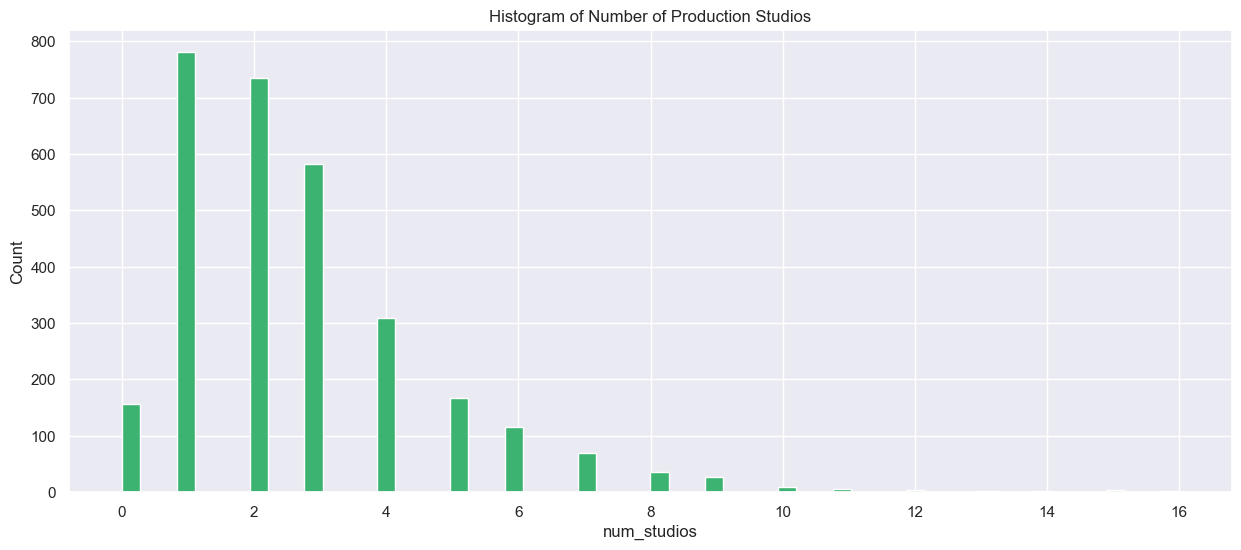

In [119]:
# Plotting films by the number of production studios
sns.set(rc={'figure.figsize': (15, 6)})  # Set figure size

# Plot histogram of the number of production studios
sns.histplot(train['num_studios'], kde=False, color='mediumseagreen', alpha=1)

# Add title to the plot
plt.title('Histogram of Number of Production Studios')

# Show the plot
plt.show()

Most movies have between 1 and 4 production studios, with fewer films having higher numbers and some even having 0 studio partners (independent films). However, simply looking at the number of production studios may not provide enough insight to make a reasonable hypothesis about a film’s box office success. 

A more effective approach would be to identify larger, more established, or historically successful production studios. By analyzing the presence of these studios in the dataset, we can better assess their impact on the box office performance of the films in question.

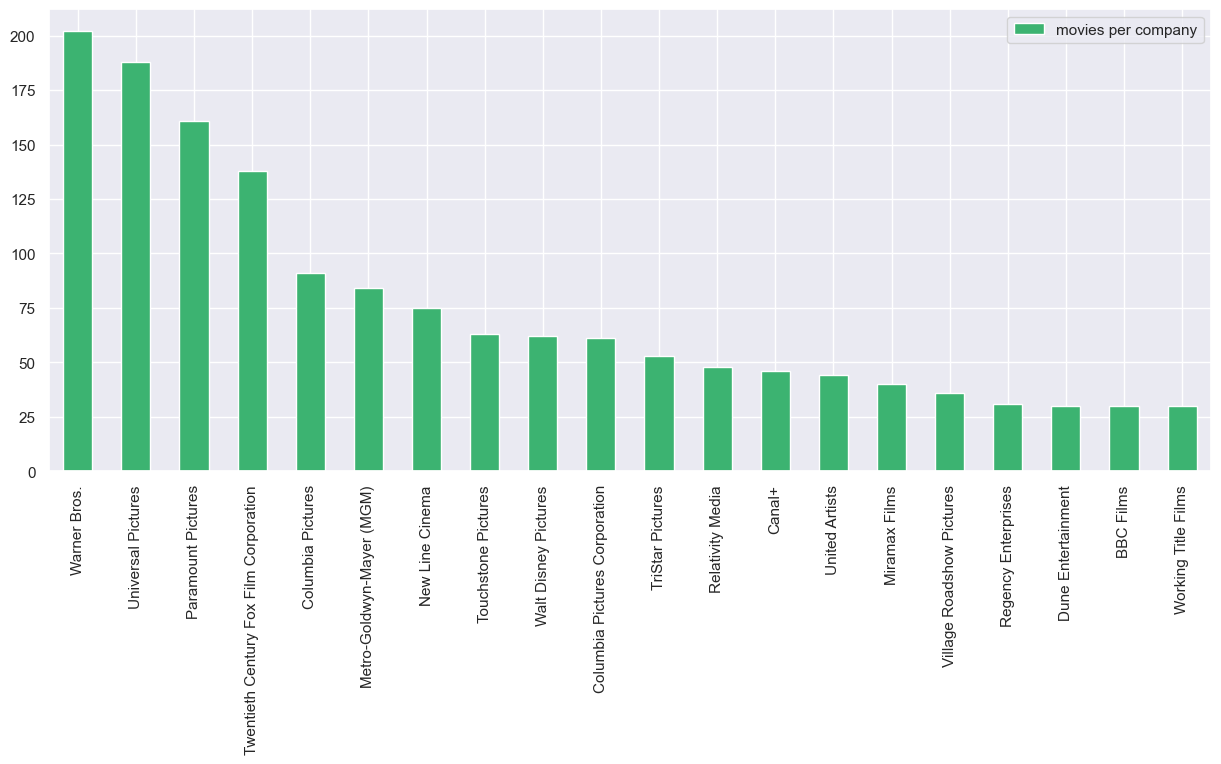

In [121]:
# Create a dictionary to count the number of movies each production company worked on
companiesDict = {}
for element in train["production_companies_reform"].values:
    for company in element:
        if company not in companiesDict:
            companiesDict[company] = 1  # If the company is not in the dict, add it
        else:
            companiesDict[company] += 1  # Otherwise, increment the count

# Convert the dictionary to a DataFrame
companies_train = pd.DataFrame.from_dict(companiesDict, orient='index', columns=["movies per company"])

# Sort the DataFrame by the number of movies each company worked on and plot the top 20 companies
companies_train.sort_values(by="movies per company", ascending=False).head(20).plot.bar(color='mediumseagreen')

# Rename the column for clarity
companies_train.columns = ["number_of_studios"]

Using the number of movies per production company may be helpful in identifying the largest studios and examining how the size of a production company influences the success of its films. There are two possibilities to consider: 

1. A larger studio has the resources and connections to attract big-name cast and crew, as well as the experience needed to turn a project into a box office success.
2. Alternatively, the studio might be too franchised, continually producing films that perform mediocrely, lacking originality or novelty.

While both scenarios are plausible, machine learning can help determine the relative influence of studio size on a movie's predicted revenue. Marking whether or not a major studio is involved in a film will serve as a useful feature in identifying this connection.

### Bivariate Analysis

In [124]:
# Count the number of movies each production studio worked on
companiesDict2 = {}
for element in df["production_companies_reform"].values:
    for company in element:
        companiesDict2[company] = companiesDict2.get(company, 0) + 1

# Convert the dictionary to a DataFrame
companies_df = pd.DataFrame.from_dict(companiesDict2, orient='index', columns=["number_of_studios"])

# Create binary columns for each production studio using pd.concat
binary_columns = pd.DataFrame({g: df['production_companies_reform'].apply(lambda x: 1 if g in x else 0) 
                               for g in companies_df.index.values}, index=df.index)

# Concatenate the binary columns with the original df at once to avoid fragmentation
df = pd.concat([df, binary_columns], axis=1)

# Calculate median, mean, and total revenue per studio
companies_df['median_rev'] = companies_df.index.map(lambda g: df[df[g] == 1]['revenue'].median())
companies_df['mean_rev'] = companies_df.index.map(lambda g: df[df[g] == 1]['revenue'].mean())
companies_df['sum_rev'] = companies_df.index.map(lambda g: df[df[g] == 1]['revenue'].sum())

# Display top 10 studios by number of studios and revenue metrics
companies_df.sort_values(by=["number_of_studios", "median_rev"], ascending=False).head(10)
companies_df.sort_values(by=["number_of_studios", "mean_rev"], ascending=False).head(10)
companies_df.sort_values(by=["number_of_studios", "sum_rev"], ascending=False).head(10)

,number_of_studios,median_rev,mean_rev,sum_rev
Warner Bros.,202,55653705.5,1.203347e+08,24307604057
Universal Pictures,188,59540581.5,1.096708e+08,20618115682
Paramount Pictures,161,52034889.0,1.247831e+08,20090073288
Twentieth Century Fox Film Corporation,138,50589532.0,1.139619e+08,15726744362
Columbia Pictures,91,77737889.0,1.202844e+08,10945881977
Metro-Goldwyn-Mayer (MGM),84,13220811.0,6.872146e+07,5772602276
New Line Cinema,75,60740827.0,1.451592e+08,10886938228
Touchstone Pictures,63,34808403.0,7.654655e+07,4822432480
Walt Disney Pictures,62,160440216.0,3.037771e+08,18834179118
Columbia Pictures Corporation,61,58853106.0,7.591135e+07,4630592046


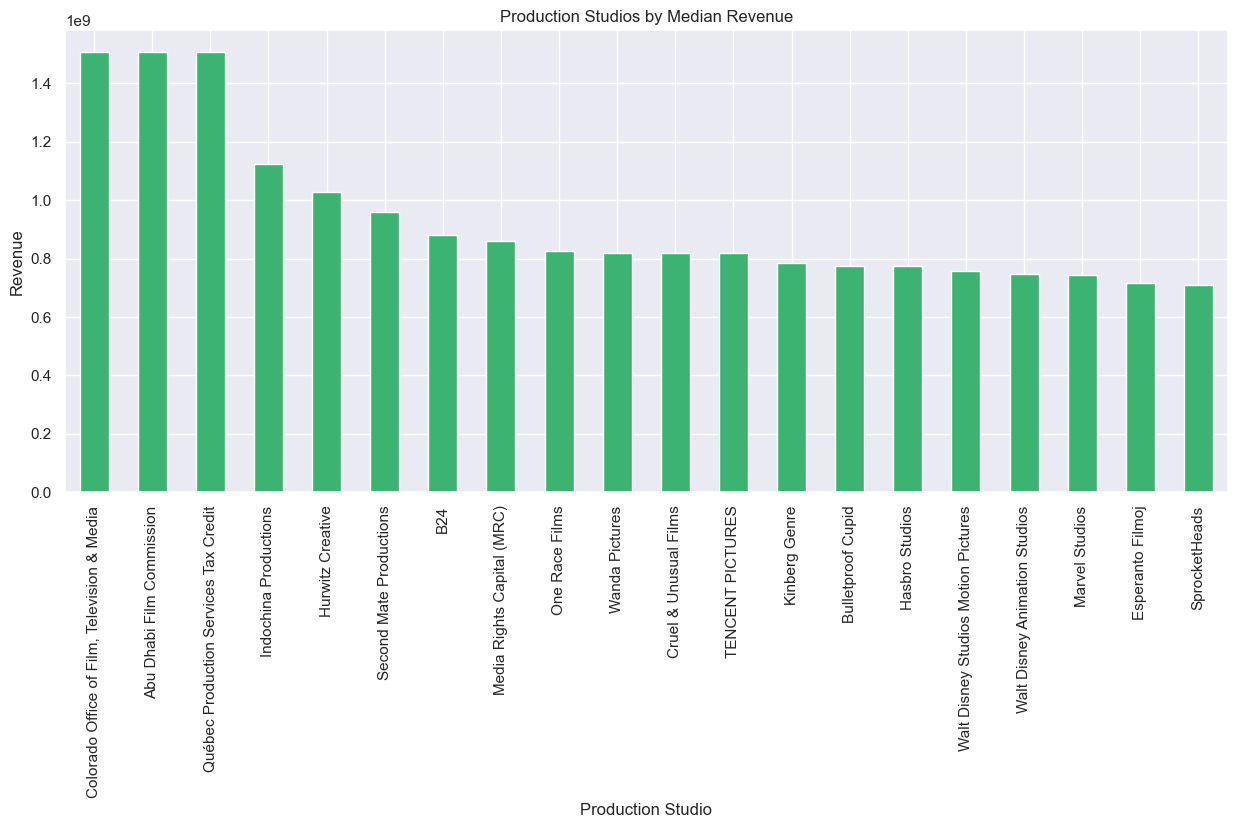

In [125]:
# Production studios by median revenue
companies_df.sort_values(by=["median_rev"], ascending=False).median_rev.head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Production Studios by Median Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

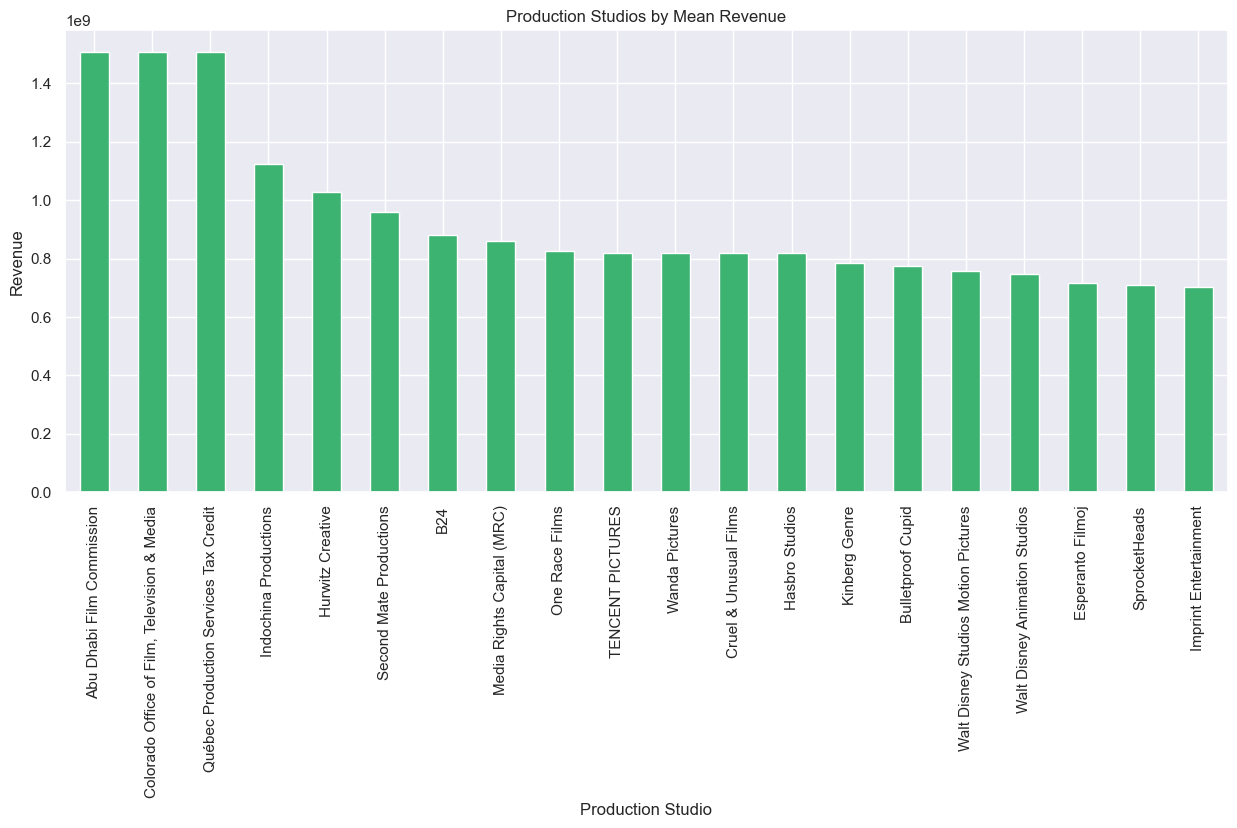

In [126]:
# Production studios by mean revenue
companies_df.sort_values(by=["mean_rev"], ascending=False).mean_rev.head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

Both mean and median revenue compared to the production studio yield relatively uninformative results. For example, the Colorado Office of Film, Television & Media appears as a minor production studio for *Furious 7* from the *Fast & Furious* franchise. This is the only time it appears on the list, significantly skewing its perceived influence on a film's revenue. Similarly, the Abu Dhabi Film Commission is involved in *Furious 7* and seven other films, including the highly profitable *Ghost Rider: Spirit of Vengeance*. These outliers are given undue importance using this system.

To improve this analysis, two approaches can be considered:

1. Analyzing the total revenue of each production company to identify the studios with the overall highest box office totals (though this may mirror the largest studios that have worked on the greatest number of films).
2. Applying the mean and median revenue values only to the primary production company working on each film, reducing the influence of minor or secondary studios on the analsis.


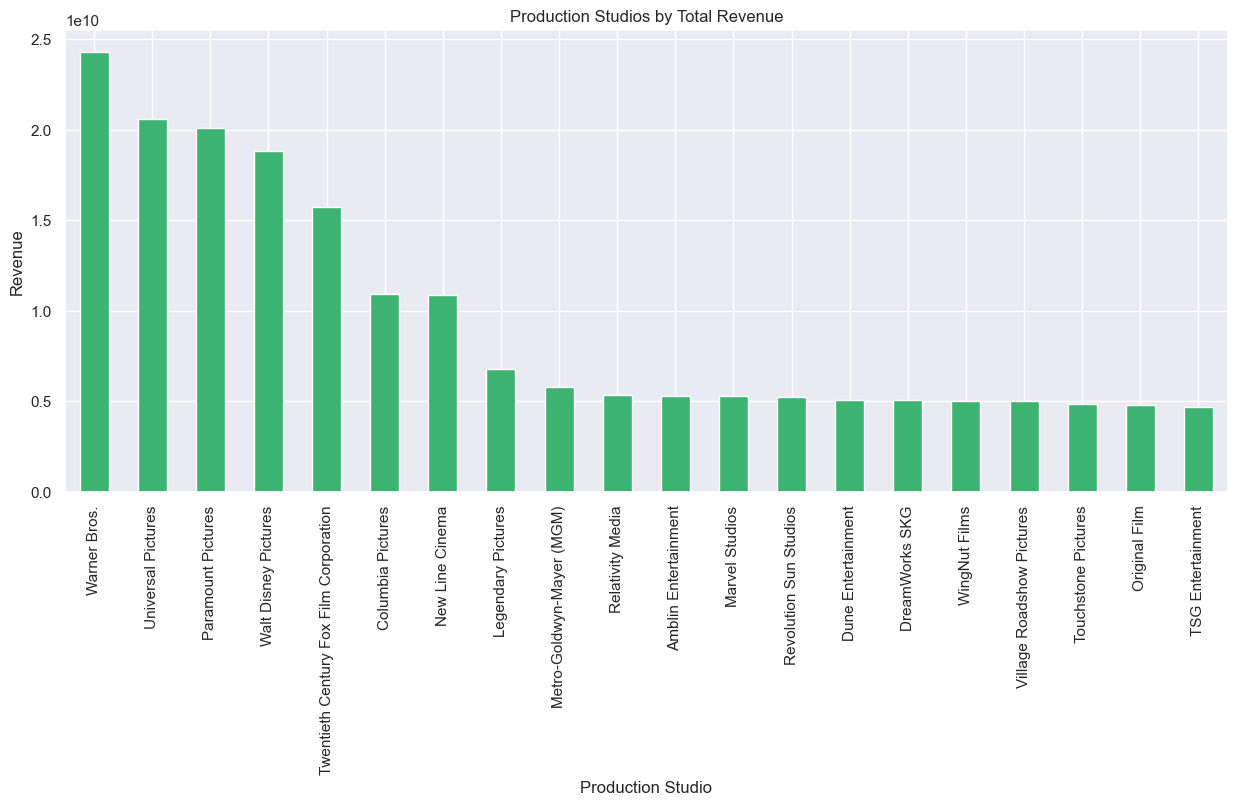

In [128]:
# Production studios by total revenue
companies_df.sort_values(by=["sum_rev"], ascending=False).sum_rev.head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Production Studios by Total Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

As expected, the production studios largely reflect the ones with the greatest number of films produced. One notable exception is Walt Disney Pictures, which rises from ninth place in terms of films produced to fourth place in total revenue. While other studios shift positions slightly, it would be worthwhile to analyze the impact of primary production studios to gain a clearer understanding of their influence on box office success.

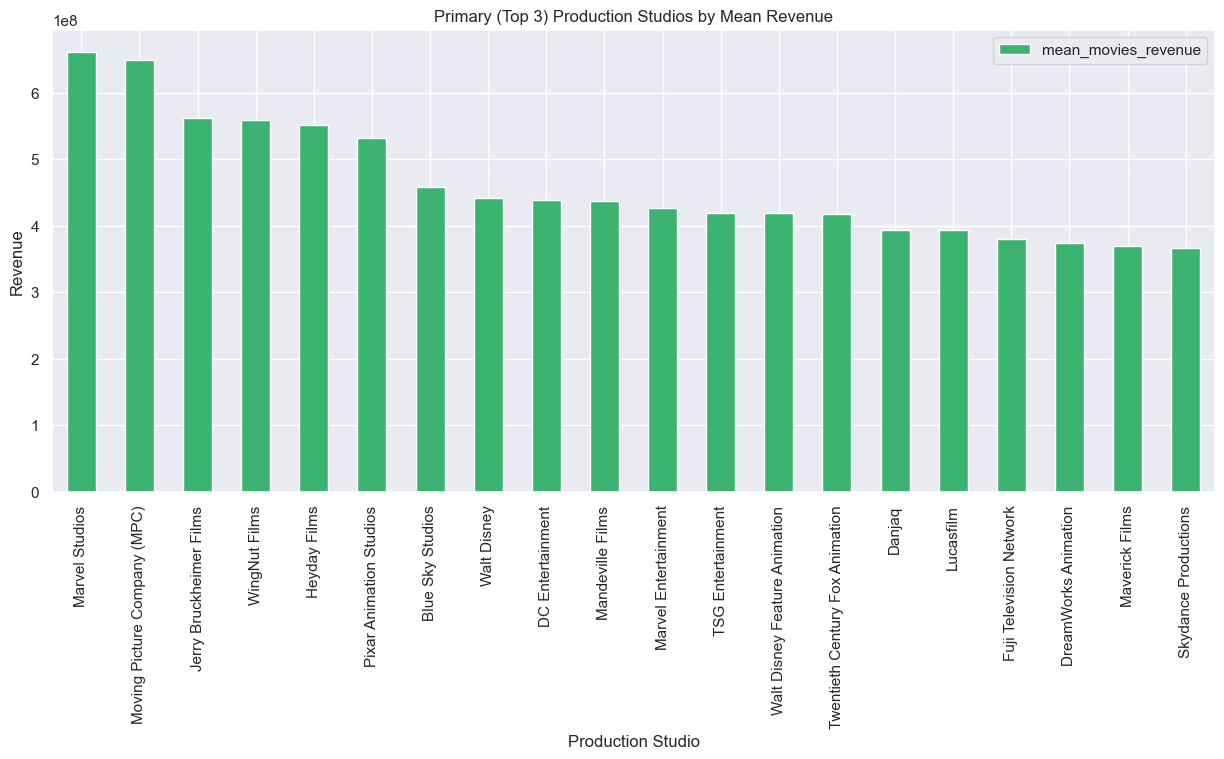

In [130]:
# Isolating the primary production studios for the films
studiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
    # Compare results when looking at top 3 production companies in films vs. all affiliated studios
    temp = 3
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in studiosDict:
            studiosDict[element[1][i]] = [element[0], 1]
        else:
            studiosDict[element[1][i]][0] += element[0]
            studiosDict[element[1][i]][1] += 1    

# Only include studios involved in at least 3 films
studiosDict = {k: v for k, v in studiosDict.items() if v[1] >= 3}

# Calculate the mean revenue per studio
for company in studiosDict:
    studiosDict[company][0] = studiosDict[company][0] / studiosDict[company][1]
    studiosDict[company] = studiosDict[company][0]

# Create DataFrame from the dictionary and plot the top 20 studios by mean revenue
studios_train = pd.DataFrame.from_dict(studiosDict, orient='index', columns=["mean_movies_revenue"])
studios_train.sort_values(by="mean_movies_revenue", ascending=False).head(20).plot.bar(color='mediumseagreen')

# Add title and labels to the plot
plt.title("Primary (Top 3) Production Studios by Mean Revenue")
plt.ylabel("Revenue")
plt.xlabel("Production Studio")

# Show the plot
plt.show()

When isolating the top three production studios from a film's `production_companies` feature, the resulting bar plot for mean revenue by production studio shows a different picture. Notably, film commissions involved only in regional media permitting for one or a few high-revenue films (such as the Colorado Office of Film, Television & Media for *Furious 7*) are filtered out. This method provides a more accurate analysis of production studios based on mean revenue, focusing on the primary studios.

By isolating the top production studios, this approach prevents minor studios from distorting the results. It also mitigates the effect of large studios with vast filmographies, such as Warner Bros., which might otherwise be overvalued in terms of total revenue. The method ensures a more balanced analysis of production studio performance.

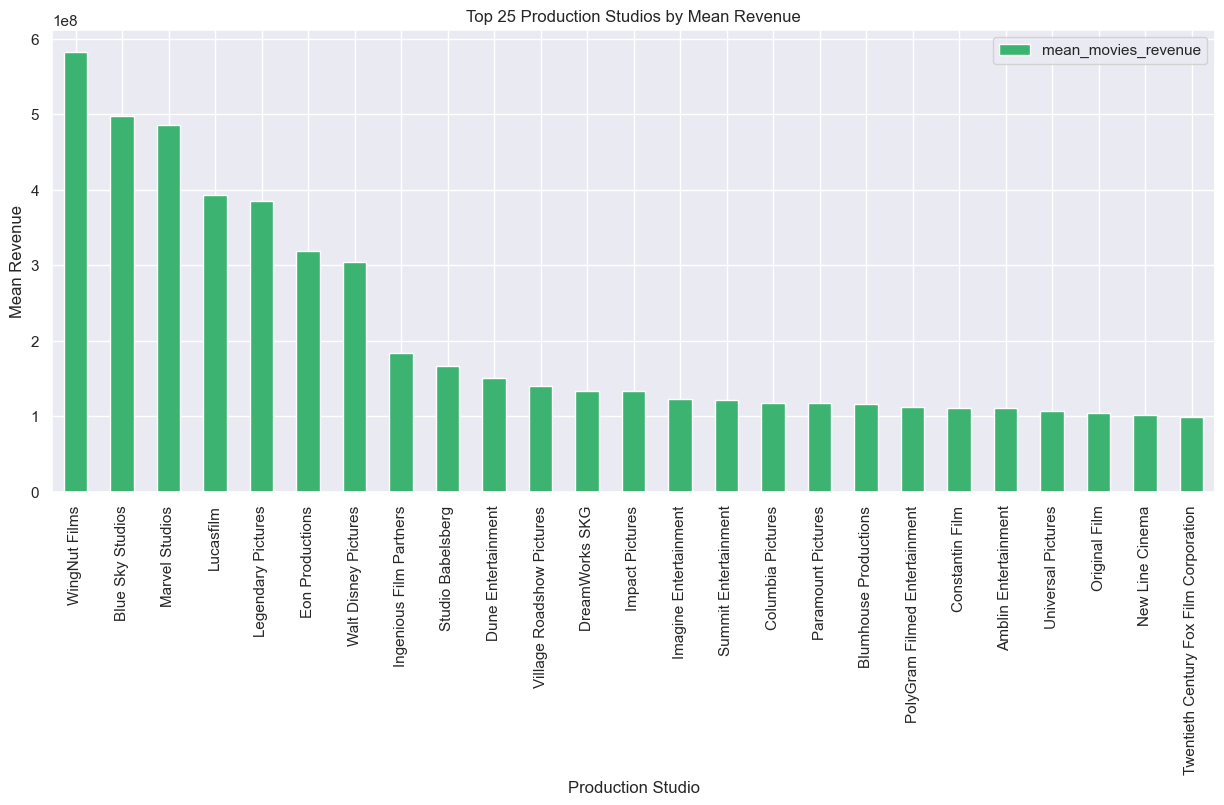

In [132]:
# Creating a dictionary for top production studios
topStudiosDict = {}
for element in train[["revenue", "production_companies_reform"]].values:
    temp = 1  # Focusing on the top studio (first studio)
    if len(element[1]) < temp:
        temp = len(element[1])
    for i in range(temp):
        if element[1][i] not in topStudiosDict:
            topStudiosDict[element[1][i]] = [element[0], 1]  # Initialize with revenue and count
        else:
            topStudiosDict[element[1][i]][0] += element[0]  # Add revenue
            topStudiosDict[element[1][i]][1] += 1  # Increment count

# Filter out studios with fewer than 5 films
topStudiosDict = {k: v for k, v in topStudiosDict.items() if v[1] >= 5}

# Calculate the mean revenue per studio
for company in topStudiosDict:
    topStudiosDict[company][0] = topStudiosDict[company][0] / topStudiosDict[company][1]
    topStudiosDict[company] = topStudiosDict[company][0]

# Convert to DataFrame and plot the top 25 studios by mean revenue
studios_df = pd.DataFrame.from_dict(topStudiosDict, orient='index', columns=["mean_movies_revenue"])
studios_df.sort_values(by="mean_movies_revenue", ascending=False).head(25).plot.bar(color='mediumseagreen')

# Show the plot
plt.title("Top 25 Production Studios by Mean Revenue")
plt.ylabel("Mean Revenue")
plt.xlabel("Production Studio")
plt.show()

In [133]:
# Sort both dictionaries to easily access the most successful studios
topStudiosDict = {k: v for k, v in sorted(topStudiosDict.items(), key=lambda item: item[1], reverse=True)}
studiosDict = {k: v for k, v in sorted(studiosDict.items(), key=lambda item: item[1], reverse=True)}

# Function to check if the lead studio is a 'top studio'
def checkTopStudios(studio):
    return 1 if len(studio) > 0 and studio[0] in list(topStudiosDict)[:50] else 0

# Function to count the number of 'top studios' in a movie
def checkStudios(studio):
    return sum(1 for company in studio[:10] if company in list(studiosDict)[:100])

# Function to calculate studio rank based on their success
def getStudioRanks(studios):
    rank = sum(list(studiosDict.keys()).index(s) for s in studios[:5] if s in studiosDict)
    return rank / len(studios) if rank > 0 else 400

# Create features for top production studios
train['topStudio'] = train['production_companies_reform'].apply(checkTopStudios)
test['topStudio'] = test['production_companies_reform'].apply(checkTopStudios)

# Create feature for number of top studios
train['numTopStudios'] = train['production_companies_reform'].apply(checkStudios)
test['numTopStudios'] = test['production_companies_reform'].apply(checkStudios)

# Create feature for studio rank
train['studioRank'] = train['production_companies_reform'].apply(getStudioRanks)
test['studioRank'] = test['production_companies_reform'].apply(getStudioRanks)

# Display value counts for the new features
print(train['topStudio'].value_counts())
print()
print(train['numTopStudios'].value_counts())
print()
print(train['studioRank'].value_counts())

topStudio
0    1682
1    1318
Name: count, dtype: int64

numTopStudios
0    2187
1     597
2     158
3      52
4       4
5       2
Name: count, dtype: int64

studioRank
400.000000    797
91.000000      52
109.000000     40
248.000000     34
101.000000     33
             ... 
33.333333       1
256.000000      1
211.250000      1
81.500000       1
67.666667       1
Name: count, Length: 983, dtype: int64


In [134]:
len(studiosDict)

399

In an effort to quantify the impact of production studios, we created two dictionaries: one for all production studios involved in the films and another for the primary studios (i.e., the first one listed for each film). Both were sorted based on the average revenue.

We then added two new columns to the dataset:
- **`topStudio`**: This column indicates whether the primary studio listed is one of the top 25 primary studios based on revenue.
- **`numTopStudios`**: This column counts the number of top studios (by revenue) that worked on a given film.

These columns help measure the influence of both the primary studio and the total number of high-revenue studios involved in a film's production.

In [136]:
# Correlation analysis for topStudio
corr, _ = pearsonr(train['topStudio'], train['revenue'])
print('Pearsons correlation between topStudio and revenue: %.3f' % corr)
corr, _ = pearsonr(train['topStudio'], np.log1p(train['revenue']))
print('Pearsons correlation between topStudio and log-transformed revenue: %.3f' % corr)
print()

# Correlation analysis for numTopStudios
corr, _ = pearsonr(train['numTopStudios'], train['revenue'])
print('Pearsons correlation between numTopStudios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['numTopStudios']), np.log1p(train['revenue']))
print('Pearsons correlation between numTopStudios and log-transformed revenue: %.3f' % corr)
print()

# Correlation analysis for studioRank
corr, _ = pearsonr(train['studioRank'], train['revenue'])
print('Pearsons correlation between studioRank and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['studioRank']), np.log1p(train['revenue']))
print('Pearsons correlation between log-transformed studioRank and log-transformed revenue: %.3f' % corr)
print()

# Correlation analysis for num_studios
corr, _ = pearsonr(train['num_studios'], train['revenue'])
print('Pearsons correlation between num_studios and revenue: %.3f' % corr)
corr, _ = pearsonr(np.log1p(train['num_studios']), np.log1p(train['revenue']))
print('Pearsons correlation between log-transformed num_studios and log-transformed revenue: %.3f' % corr)

Pearsons correlation between topStudio and revenue: 0.320
Pearsons correlation between topStudio and log-transformed revenue: 0.436

Pearsons correlation between numTopStudios and revenue: 0.558
Pearsons correlation between numTopStudios and log-transformed revenue: 0.419

Pearsons correlation between studioRank and revenue: -0.334
Pearsons correlation between log-transformed studioRank and log-transformed revenue: -0.451

Pearsons correlation between num_studios and revenue: 0.154
Pearsons correlation between log-transformed num_studios and log-transformed revenue: 0.269


We observe a moderate positive correlation between our created columns used to quantify the top studios, which is encouraging as it may suggest some predictive ability for revenue. Additionally, there is a weaker positive correlation between the number of studios involved in a film and its revenue. This indicates that while the involvement of more studios has some impact, it is not as strongly correlated as the influence of top studios.

In [138]:
train_features.append('topStudio')
log_features.append('numTopStudios')
log_features.append('num_studios')
log_features.append('studioRank')

### Release Date
The release date represents when a movie was first released in theaters. Factors such as the day of the week, season, or time of year can influence a movie's performance at the box office. These aspects can be derived from the release date and may play a significant role in predicting the movie's success


In [140]:
# Display the first 10 entries in the 'release_date' column
# This shows the top 10 rows of the release date feature to verify or explore the data.
train['release_date'].head(10)

0     2/20/15
1      8/6/04
2    10/10/14
3      3/9/12
4      2/5/09
5      8/6/87
6     8/30/12
7     1/15/04
8     2/16/96
9     4/16/03
Name: release_date, dtype: object

The `release_date` column appears to be formatted as standard dates, but to extract valuable insights such as the day of the week, month, year, or season, we need to break this data down further. We'll begin by applying some pre-processing using Python's `datetime` module for more effective data manipulation and feature extraction.

### Pre-processing

In [143]:
# Pre-processing: Release Date Data Manipulation

# Create a separate dataframe/series for release date to maintain clean code structure
train_date = train['release_date']

# Convert the 'release_date' column to datetime format
# This ensures the column is recognized as actual dates, enabling easier manipulation
train_date = pd.to_datetime(train_date, format='%m/%d/%y')

# .dt allows us to access datetime properties such as year, month, day, etc.
print(train_date.dt)

# Printing the converted 'release_date' column to verify the changes
print(train_date)

0      2015-02-20
1      2004-08-06
2      2014-10-10
3      2012-03-09
4      2009-02-05
          ...    
2995   1994-04-22
2996   2013-03-28
2997   1996-10-11
2998   2004-01-16
2999   2011-09-22
Name: release_date, Length: 3000, dtype: datetime64[ns]


In [144]:
# Possible output options for date feature extraction

# Extracting and printing the year from the release date
print(train_date.dt.year)  # Absolutely necessary for most analyses

# Extracting and printing the day of the week (0=Monday, 6=Sunday)
print(train_date.dt.dayofweek)  # Friday night hits! Useful to analyze the effect of release day

# Extracting and printing the day of the year (1=Jan 1, 365=Dec 31)
print(train_date.dt.dayofyear)  # It's a Christmas miracle! Could be used to track seasonal trends

# Extracting and printing the week of the year (ISO week)
print(train_date.dt.isocalendar().week)  # Week of interest, useful for time-series analysis

0       2015
1       2004
2       2014
3       2012
4       2009
        ... 
2995    1994
2996    2013
2997    1996
2998    2004
2999    2011
Name: release_date, Length: 3000, dtype: int32
0       4
1       4
2       4
3       4
4       3
       ..
2995    4
2996    3
2997    4
2998    4
2999    3
Name: release_date, Length: 3000, dtype: int32
0        51
1       219
2       283
3        69
4        36
       ... 
2995    112
2996     87
2997    285
2998     16
2999    265
Name: release_date, Length: 3000, dtype: int32
0        8
1       32
2       41
3       10
4        6
        ..
2995    16
2996    13
2997    41
2998     3
2999    38
Name: week, Length: 3000, dtype: UInt32


In [145]:
# Print summary statistics for the 'release_date' column before converting to datetime
# This will show general statistics like count, unique values, and the most frequent values.
print(train['release_date'].describe())

# Print a blank line for better readability
print()

# After converting 'release_date' to datetime (stored in 'train_date'), 
# print the summary statistics for the 'year' extracted from the date
# This will show count, mean, standard deviation, min, and max year values.
print(train_date.dt.year.describe())

count        3000
unique       2398
top       9/10/10
freq            5
Name: release_date, dtype: object

count    3000.000000
mean     2004.579667
std        15.480790
min      1969.000000
25%      1995.000000
50%      2006.000000
75%      2012.000000
max      2068.000000
Name: release_date, dtype: float64


### Univariate Analysis

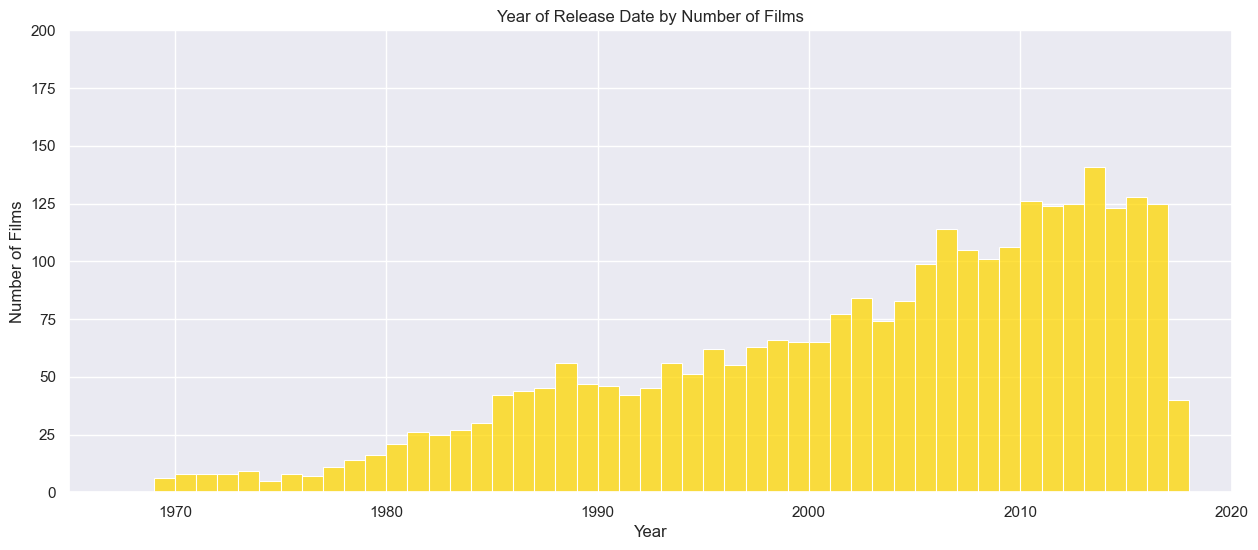

In [147]:
# Plotting the distribution of film release years
fig, dx = plt.subplots()

# Create a histogram of the release year, no Kernel Density Estimate (kde=False)
# Using 'gold' as the color with full opacity (alpha=1)
sns.histplot(train_date.dt.year, bins=99, color='gold', kde=False)

# Set figure size
sns.set(rc={'figure.figsize': (12, 6)})

# Adjust x and y limits for better visualization
dx.set(xlim=(1965, 2020), ylim=(0, 200))

# Set labels for the axes
dx.set_xlabel("Year")
dx.set_ylabel("Number of Films")

# Set the title of the plot
dx.set_title("Year of Release Date by Number of Films")

# Show the plot
plt.show()

The plot showing the year of release for the dataset reveals a general increase in the number of films over time, which aligns with the growth and maturation of the film industry. While the trend appears mostly linear, there are notable peaks during certain years. Investigating the relationship between these years with above-average film releases and their corresponding revenues could provide valuable insights into industry trends and profitability.

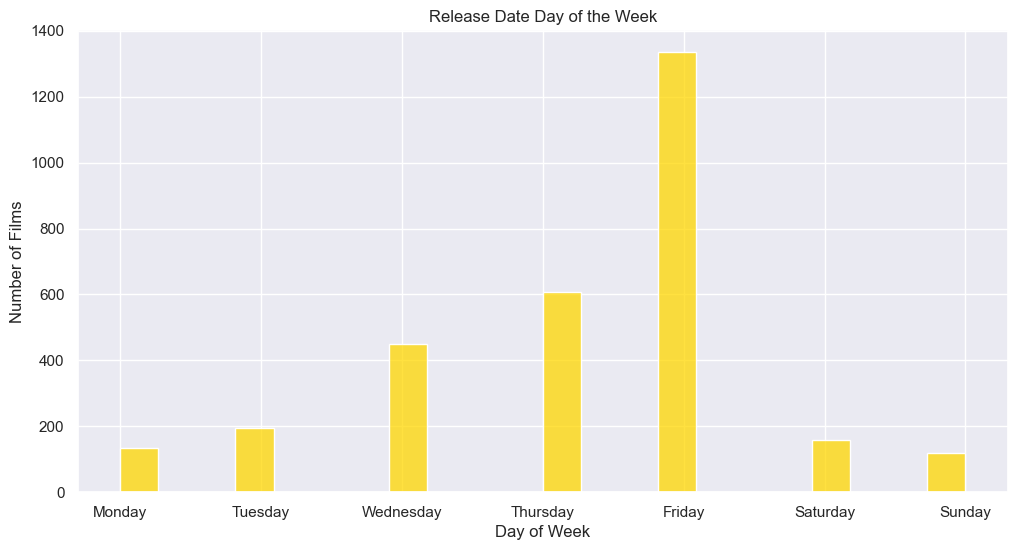

In [149]:
# Plotting the distribution of film release days (day of the week)
fig, ex = plt.subplots()

# Create a histogram for the release day of the week (0=Monday, 6=Sunday)
# Using 'gold' color with full opacity (alpha=1) and no Kernel Density Estimate (kde=False)
sns.histplot(train_date.dt.dayofweek, kde=False, color='gold')

# Set figure size
sns.set(rc={'figure.figsize': (15, 6)})

# Set labels for the x-axis and y-axis
ex.set_xlabel("Day of Week")
ex.set_ylabel("Number of Films")

# Set title for the plot
ex.set_title("Release Date Day of the Week")

# Customizing x-axis labels to show the names of the days instead of numbers
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ex.set_xticks(range(7))  # Ensure ticks are set from 0 to 6
ex.set_xticklabels(labels)  # Set the custom day labels

# Show the plot
plt.show()

The day-of-week data reveals a clear outlier, with Friday being the most common release day. This trend is likely tied to the end of the typical Monday-to-Friday workweek, as individuals are more inclined to attend a multi-hour event like a movie when they have fewer responsibilities the following day. Movie releases tend to follow market patterns that maximize potential sales, suggesting that Friday releases are strategically chosen to boost box office performance. Interestingly, Saturday release dates are lower than expected, even compared to midweek days like Tuesday, Wednesday, and Thursday, despite the assumption that many movie-goers would attend a film opening on a Saturday.

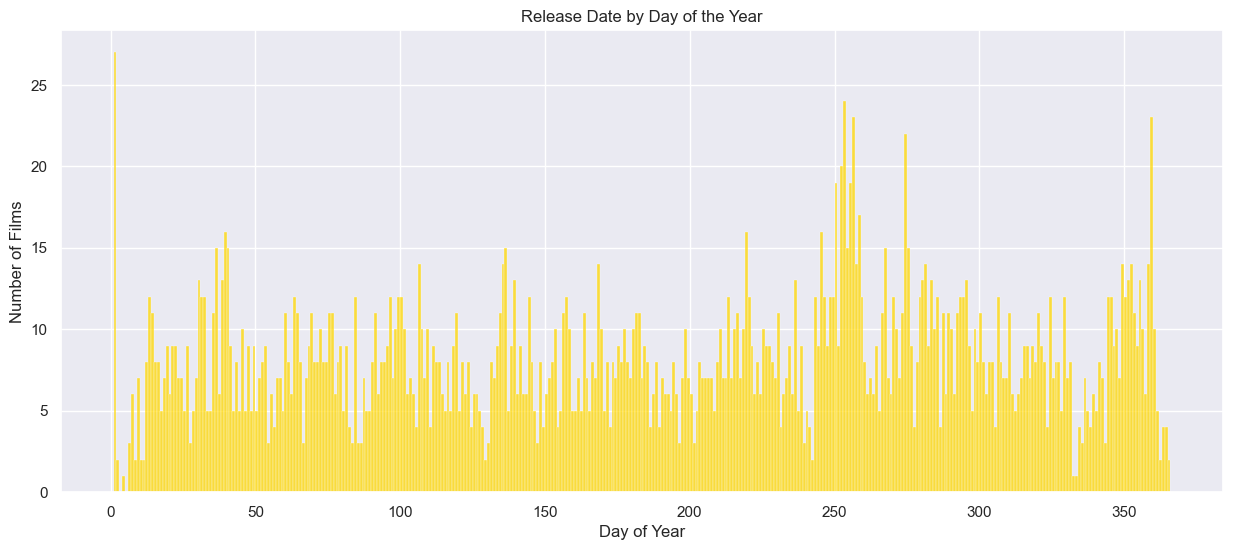

In [151]:
# Plotting the distribution of film release days of the year
fig, fx = plt.subplots()

# Create a histogram for the release day of the year (1-365)
# Using 'gold' color and no Kernel Density Estimate (kde=False)
# 'bins=365' ensures each day of the year is represented by a bin
sns.histplot(train_date.dt.dayofyear, bins=365, kde=False, color='gold')

# Set figure size for better visibility
sns.set(rc={'figure.figsize': (15, 6)})

# Set labels for the x-axis and y-axis
fx.set_xlabel("Day of Year")  # X-axis represents the day of the year (1-365)
fx.set_ylabel("Number of Films")  # Y-axis represents the number of films released
fx.set_title("Release Date by Day of the Year")  # Title for the plot

# Show the plot
plt.show()

The day-of-year data shows some expected patterns, but overall, it is a fairly noisy dataset. Certain days, such as Christmas Eve and New Year's Day, stand out with significantly higher numbers of film releases, as these dates are well-known for movie premieres. It remains to be explored whether these release dates are rooted more in tradition or if they genuinely lead to higher box office revenues.

Interestingly, there is a notable clustering of films released in September. Upon further investigation, this aligns with the concept of "dump months"—periods like August and September when studios often release films that performed poorly in testing, feature less prominent casts, or are harder to market. This timing coincides with children returning to school and other factors contributing to a seasonal slump for the film industry. As such, a high number of releases during these periods could either have positive or negative effects, depending on the context. It's also possible that periods with fewer releases might occur due to the presence of a major title, with studios avoiding competition at the box office.

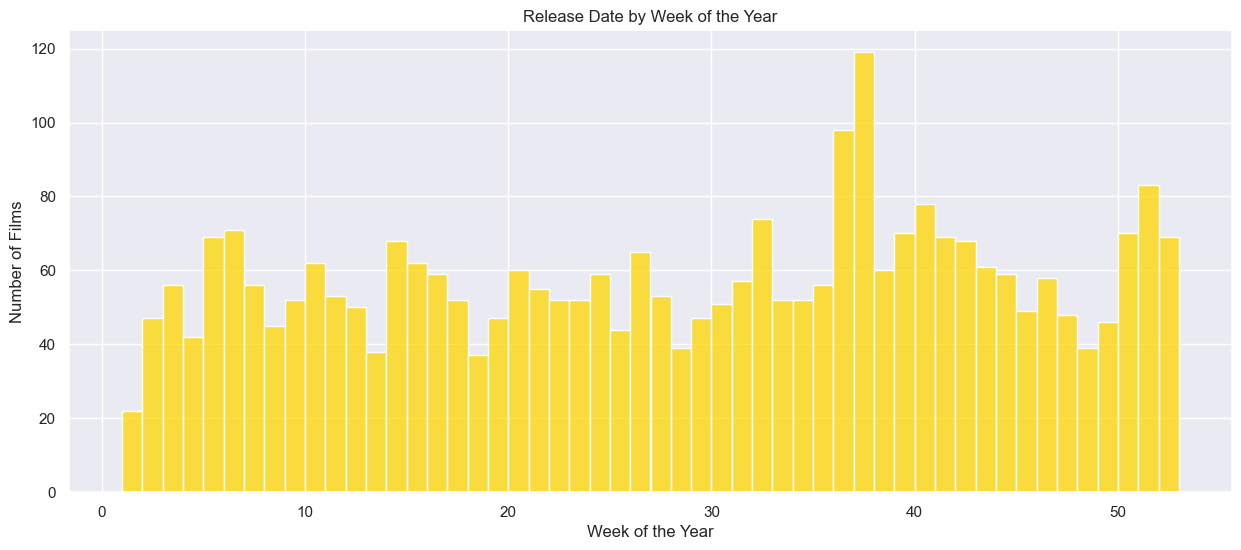

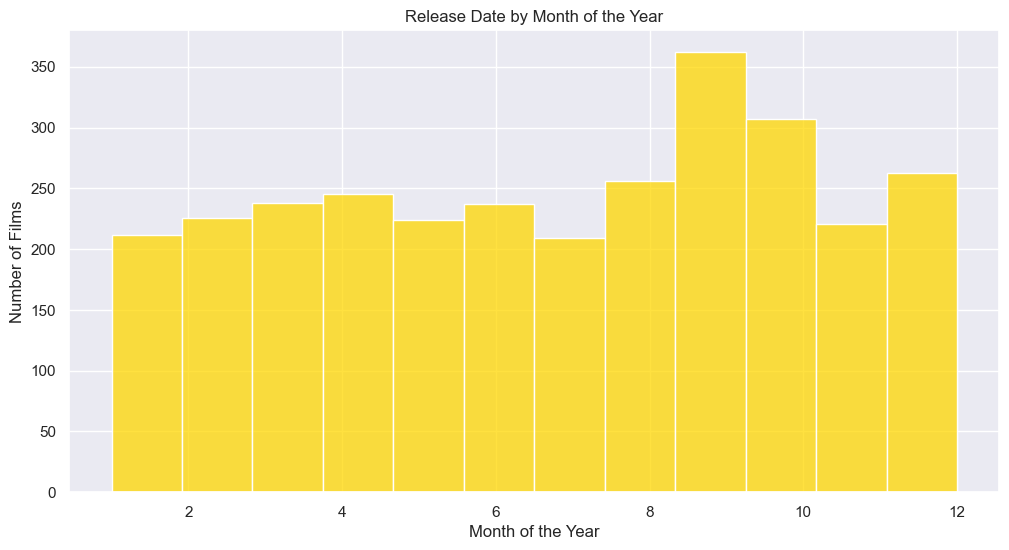

In [153]:
# Plotting the films release week of the year
fig, gx = plt.subplots()

# 'weekofyear' is deprecated, so use 'isocalendar().week' instead
sns.histplot(train_date.dt.isocalendar().week, bins=52, kde=False, color='gold')

# Set figure size for better visibility
sns.set(rc={'figure.figsize': (12, 6)})

# Set labels for the axes and the title
gx.set_xlabel("Week of the Year")
gx.set_ylabel("Number of Films")
gx.set_title("Release Date by Week of the Year")

plt.show()

# Plotting the films release month of the year
fig, hx = plt.subplots()

# Create a histogram for the release month of the year
sns.histplot(train_date.dt.month, bins=12, kde=False, color='gold')

# Set figure size for better visibility
sns.set(rc={'figure.figsize': (12, 6)})

# Set labels for the axes and the title
hx.set_xlabel("Month of the Year")
hx.set_ylabel("Number of Films")
hx.set_title("Release Date by Month of the Year")

plt.show()

Similar to the day-of-year data, the week-of-year data shows the highest concentration of film releases in late August and early September. As these weeks fall within the so-called "dump months," this trend is unlikely to indicate a positive correlation with revenue. In contrast, the second largest spike occurs in December, which may be more aligned with higher box office earnings due to the tradition of movie-going during the holidays. Additionally, late fall and early winter mark the start of Oscar Season, when studios often release higher-grossing films, regardless of the overall number of releases. This suggests that the sheer number of films released in a given week is less significant than the characteristics of that week in relation to the film industry's cyclical patterns.

### Bivariate Analysis

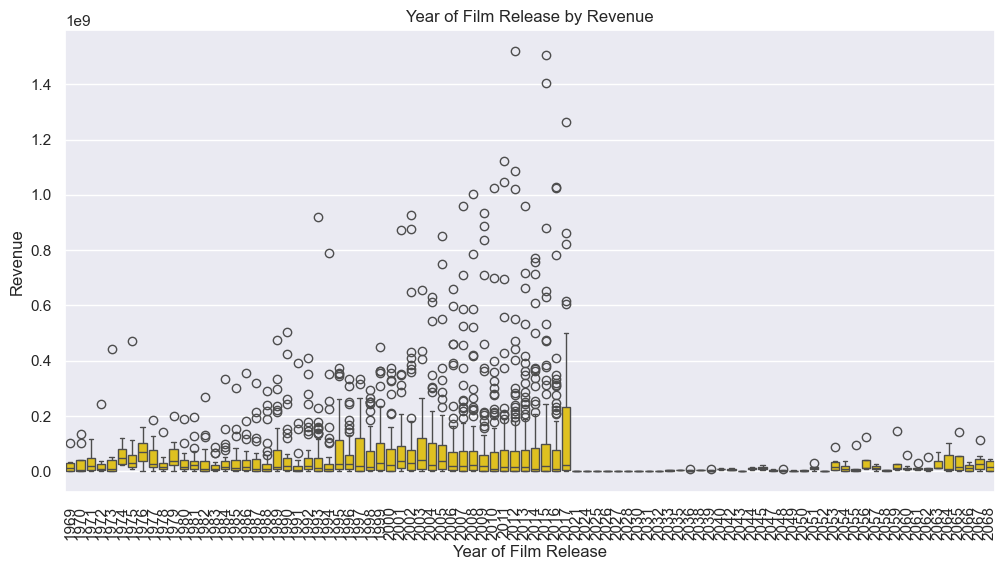

In [156]:
# Bivariate plot of year of release and revenue data using a boxplot
fig, dx = plt.subplots()

# Create a boxplot showing the distribution of revenue by year of film release
sns.boxplot(x=train_date.dt.year, y=train['revenue'], color='gold')

# Set figure size for better visibility
sns.set(rc={'figure.figsize': (12, 6)})

# Set labels for the x-axis and y-axis
dx.set_xlabel("Year of Film Release")
dx.set_ylabel("Revenue")
dx.set_title("Year of Film Release by Revenue")

# Ensure the ticks are set before rotating labels
dx.set_xticks(dx.get_xticks())  # Ensure ticks are set explicitly
dx.set_xticklabels(dx.get_xticklabels(), rotation=90)  # Rotate tick labels

# Show the plot
plt.show()

Film revenues generally show an upward trend from year to year, with certain years standing out more than others. The most recent year in the dataset, 2017, significantly surpasses previous years in terms of revenue, largely due to the massive success of *Wonder Woman*.

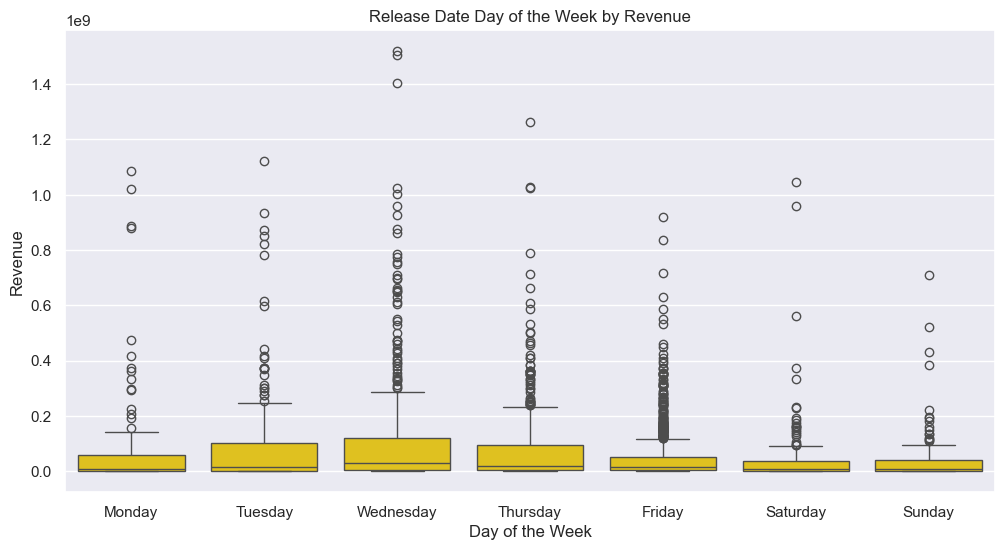

In [158]:
# Bivariate plot of day of week of release with revenue data using a boxplot
fig, ex = plt.subplots()

# Create a boxplot showing the distribution of revenue by the day of the week of film release
sns.boxplot(x=train_date.dt.dayofweek, y=train['revenue'], color='gold')

# Set figure size for better visibility
sns.set(rc={'figure.figsize': (12, 6)})

# Set labels for the x-axis and y-axis
ex.set_xlabel("Day of the Week")
ex.set_ylabel("Revenue")
ex.set_title("Release Date Day of the Week by Revenue")

# Customizing x-axis labels to show the names of the days instead of numbers (0 = Monday, 6 = Sunday)
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ex.set_xticks(range(7))  # Ensure ticks are set from 0 to 6 for the days of the week
ex.set_xticklabels(labels)  # Set the custom day labels

# Show the plot
plt.show()

Interestingly, despite the initial hypothesis that Friday releases would yield the highest revenue due to their perceived advantage in boosting sales, the data shows that Wednesday (followed by Tuesday and Thursday) has the highest revenue. This unexpected result warrants further investigation to understand the underlying reasons. Regardless, these findings will provide valuable insights to inform the outcome of the model.

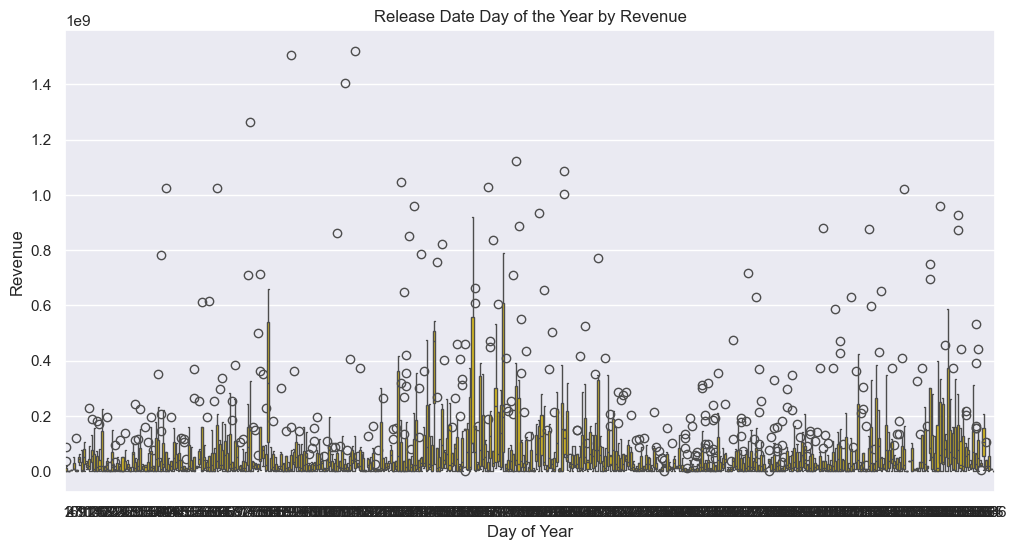

In [160]:
# Bivariate plot of day of year of release with revenue data using a boxplot
fig, fx = plt.subplots()

# Create a boxplot showing the distribution of revenue by the day of the year of film release
# 'train_date.dt.dayofyear' extracts the day of the year (1 to 365 or 366 for leap years)
sns.boxplot(x=train_date.dt.dayofyear, y=train['revenue'], color='gold')

# Set the figure size for better visibility of the plot
sns.set(rc={'figure.figsize': (12, 6)})

# Set labels for the x-axis (Day of Year) and y-axis (Revenue)
fx.set_xlabel("Day of Year")
fx.set_ylabel("Revenue")

# Set the title for the plot
fx.set_title("Release Date Day of the Year by Revenue")

# Display the plot
plt.show()

The large amount of data makes it challenging to present this plot in the same format as the other bivariate analysis plots for release date by revenue. The day-of-year data results in an overly detailed and cluttered visualization, which complicates the analysis compared to other time-based plots.

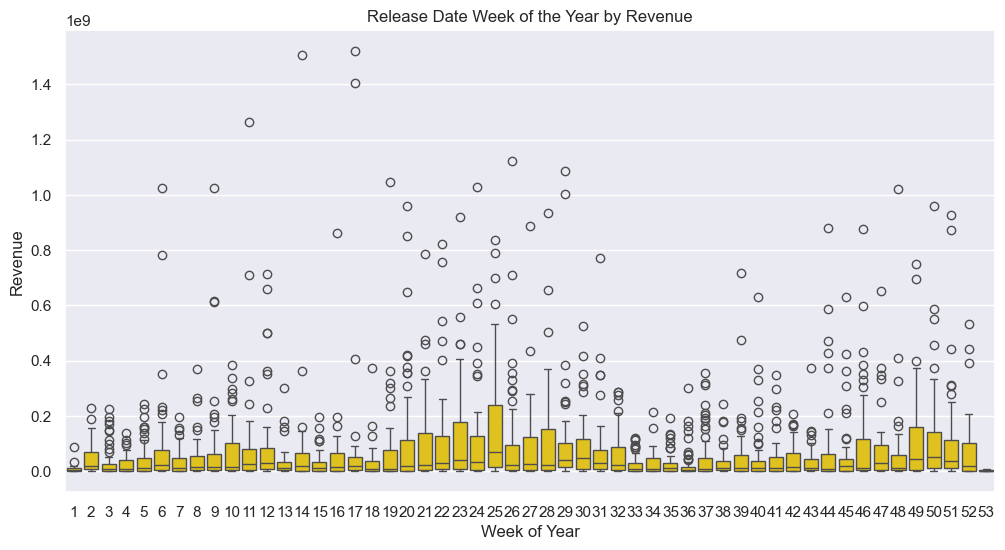

In [162]:
# Create a figure and axis for the plot
fig, gx = plt.subplots()

# Create a boxplot to visualize the distribution of revenue by the week of the year of film release
# Use 'train_date.dt.isocalendar().week' to extract the week of the year (1 to 52) from 'release_date'
sns.boxplot(x=train_date.dt.isocalendar().week, y=train['revenue'], color='gold')

# Set the figure size for better visibility of the plot elements
sns.set(rc={'figure.figsize': (12, 6)})

# Label the x-axis as "Week of Year" to show the week in the year when the film was released
gx.set_xlabel("Week of Year")

# Label the y-axis as "Revenue" to represent the revenue generated by the film
gx.set_ylabel("Revenue")

# Set the title of the plot to describe the data being shown
gx.set_title("Release Date Week of the Year by Revenue")

# Display the plot
plt.show()

The revenue data for weeks of the year aligns well with the expectations from the univariate analysis. Weeks leading up to the holiday season show relatively high revenue, as anticipated. Additionally, there is a noticeable peak in midsummer, particularly around the 25th week of the year in June, which stands out as a high-revenue period.

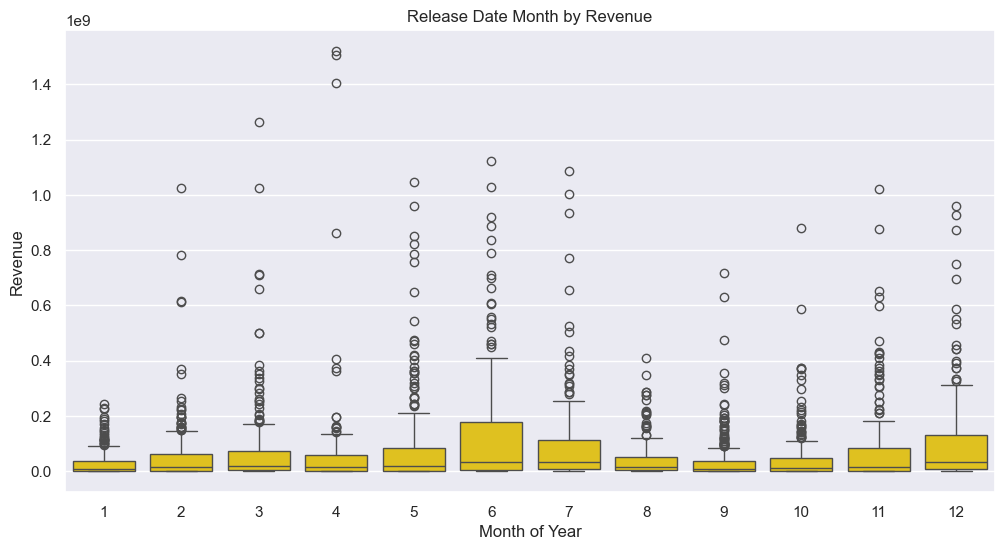

In [164]:
# Create a figure and axis for the plot
fig, hx = plt.subplots()

# Create a boxplot to visualize the distribution of revenue by the month of release
# 'train_date.dt.month' extracts the month (1 to 12) from the 'release_date'
# 'y=train['revenue']' represents the revenue generated by the films
sns.boxplot(x=train_date.dt.month, y=train['revenue'], color='gold')

# Set the figure size for better visibility
sns.set(rc={'figure.figsize': (12, 6)})

# Set the x-axis label as "Month of Year" to indicate the months when films were released
hx.set_xlabel("Month of Year")

# Set the y-axis label as "Revenue" to represent the film revenues
hx.set_ylabel("Revenue")

# Set the title of the plot to describe the data being visualized
hx.set_title("Release Date Month by Revenue")

# Display the plot
plt.show()

Similarly, the month-of-year analysis follows a comparable trend. The midsummer months, although not as high in the number of releases, tend to be more successful in terms of revenue. Conversely, the "dump months" around the start of the school year see a higher volume of film releases but significantly lower revenue. In contrast, the holiday season in December features both a higher number of releases and a corresponding spike in revenue.

In [166]:
# Fill possible missing values in 'release_date' with the mode (most common value) of the 'release_date' column
train["release_date"] = train["release_date"].fillna(train["release_date"].mode()[0])
test["release_date"] = test["release_date"].fillna(train["release_date"].mode()[0])

# Convert 'release_date' from string format to datetime objects using the format '%m/%d/%y'
# This helps in extracting specific date components like month, year, etc.
train['temp'] = train.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
test['temp'] = test.release_date.apply(lambda x: datetime.strptime(x, '%m/%d/%y'))

# Extract the month from the 'release_date' and store it in a new column 'month'
train["month"] = train.temp.apply(lambda x: x.month)
test["month"] = test.temp.apply(lambda x: x.month)

# Extract the year from the 'release_date' and store it in a new column 'year'
train["year"] = train.temp.apply(lambda x: x.year)
test["year"] = test.temp.apply(lambda x: x.year)

# Extract the day of the week (1 = Monday, 7 = Sunday) and store it in a new column 'day_of_week'
train["day_of_week"] = train.temp.apply(lambda x: x.weekday() + 1)  # Adding 1 to match typical week numbering
test["day_of_week"] = test.temp.apply(lambda x: x.weekday() + 1)

# Extract the week of the year (1 to 52) from 'release_date' using isocalendar() method
train["week_of_year"] = train.temp.apply(lambda x: x.isocalendar()[1])
test["week_of_year"] = test.temp.apply(lambda x: x.isocalendar()[1])

# Drop the temporary 'temp' column used for processing the date values
train = train.drop(['temp'], axis=1)
test = test.drop(['temp'], axis=1)

# Fill any remaining missing values in the 'day_of_week' column with the mode (most common value)
train["day_of_week"] = train["day_of_week"].fillna(train["day_of_week"].mode()[0])
test["day_of_week"] = test["day_of_week"].fillna(train["day_of_week"].mode()[0])

# Fill any remaining missing values in the 'year' column with the mode (most common value)
train["year"] = train["year"].fillna(train["year"].mode()[0])
test["year"] = test["year"].fillna(train["year"].mode()[0])

# Fill any remaining missing values in the 'month' column with the mode (most common value)
train["month"] = train["month"].fillna(train["month"].mode()[0])
test["month"] = test["month"].fillna(train["month"].mode()[0])

# Fill any remaining missing values in the 'week_of_year' column with the mode (most common value)
train["week_of_year"] = train["week_of_year"].fillna(train["week_of_year"].mode()[0])
test["week_of_year"] = test["week_of_year"].fillna(train["week_of_year"].mode()[0])

# Display the first few rows of the relevant columns from the 'train' dataset to verify the transformation
train[["release_date", "month", "year", "day_of_week", "week_of_year"]].head()

,release_date,month,year,day_of_week,week_of_year
0,2/20/15,2,2015,5,8
1,8/6/04,8,2004,5,32
2,10/10/14,10,2014,5,41
3,3/9/12,3,2012,5,10
4,2/5/09,2,2009,4,6


In [167]:
# Calculate and print the Pearson correlation between 'year' and 'revenue'
corr, _ = pearsonr(train['year'], train['revenue'])
print('Pearsons correlation between year and revenue: %.3f' % corr)

# Calculate and print the Pearson correlation between log-transformed 'year' and log-transformed 'revenue'
# Log transformation is used to reduce skewness and deal with large variance in data
corr, _ = pearsonr(np.log1p(train['year']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed year and log transformed revenue: %.3f' % corr)
print()  # Print a blank line for separation between results

# Calculate and print the Pearson correlation between 'month' and 'revenue'
corr, _ = pearsonr(train['month'], train['revenue'])
print('Pearsons correlation between month and revenue: %.3f' % corr)

# Calculate and print the Pearson correlation between log-transformed 'month' and log-transformed 'revenue'
# Again, log transformation helps in normalizing highly skewed data
corr, _ = pearsonr(np.log1p(train['month']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed month and log transformed revenue: %.3f' % corr)
print()

# Calculate and print the Pearson correlation between 'week_of_year' and 'revenue'
corr, _ = pearsonr(train['week_of_year'], train['revenue'])
print('Pearsons correlation between week_of_year and revenue: %.3f' % corr)

# Calculate and print the Pearson correlation between log-transformed 'week_of_year' and log-transformed 'revenue'
corr, _ = pearsonr(np.log1p(train['week_of_year']), np.log1p(train['revenue']))
print('Pearsons correlation between log transformed week_of_year and log transformed revenue: %.3f' % corr)
print()

Pearsons correlation between year and revenue: 0.021
Pearsons correlation between log transformed year and log transformed revenue: -0.072

Pearsons correlation between month and revenue: 0.020
Pearsons correlation between log transformed month and log transformed revenue: 0.041

Pearsons correlation between week_of_year and revenue: 0.017
Pearsons correlation between log transformed week_of_year and log transformed revenue: 0.030



The Pearson correlation analysis shows little correlation between revenue and the variables extracted from the release date. However, we will still include these variables in our model, as Pearson's correlation alone cannot fully capture the potential relationships. Rather than using these variables as continuous metrics, we should create dummy variables to better represent the relevant aspects of the release date. For example, it may not make sense to treat the year as a continuous variable or to apply a log transformation. Instead, it would be more appropriate to represent the year, along with season and day of the week, as categorical variables.

In [169]:
train.loc[train['year'].argmin(), ['title', 'year', 'revenue']]

title      The Wild Bunch
year                 1969
revenue            638641
Name: 228, dtype: object

Since the earliest movie in our dataset dates back to 1969, we will categorize the years by decade, starting with the 1960s. This approach is logical, as it's unlikely we'll be predicting any movie releases prior to this period. Grouping by decade allows us to capture any trends or patterns that may have developed over time in a more meaningful way.

In [171]:
# Create dummy variables for each decade by mapping the year into binary categories
# For each year range (1960s, 1970s, 1980s, etc.), a new column is created where:
# 1 indicates the movie was released in that decade, and 0 otherwise

# For the 1960s (1960 to 1969)
train['1960s'] = train.year.map(lambda x: 1 if (x >= 1960 and x <= 1969) else 0)
test['1960s'] = test.year.map(lambda x: 1 if (x >= 1960 and x <= 1969) else 0)

# For the 1970s (1970 to 1979)
train['1970s'] = train.year.map(lambda x: 1 if (x >= 1970 and x <= 1979) else 0)
test['1970s'] = test.year.map(lambda x: 1 if (x >= 1970 and x <= 1979) else 0)

# For the 1980s (1980 to 1989)
train['1980s'] = train.year.map(lambda x: 1 if (x >= 1980 and x <= 1989) else 0)
test['1980s'] = test.year.map(lambda x: 1 if (x >= 1980 and x <= 1989) else 0)

# For the 1990s (1990 to 1999)
train['1990s'] = train.year.map(lambda x: 1 if (x >= 1990 and x <= 1999) else 0)
test['1990s'] = test.year.map(lambda x: 1 if (x >= 1990 and x <= 1999) else 0)

# For the 2000s (2000 to 2009)
train['2000s'] = train.year.map(lambda x: 1 if (x >= 2000 and x <= 2009) else 0)
test['2000s'] = test.year.map(lambda x: 1 if (x >= 2000 and x <= 2009) else 0)

# For the 2010s (2010 to 2019)
train['2010s'] = train.year.map(lambda x: 1 if (x >= 2010 and x <= 2019) else 0)
test['2010s'] = test.year.map(lambda x: 1 if (x >= 2010 and x <= 2019) else 0)

In [172]:
train['day_of_week'].value_counts()

day_of_week
5    1335
4     609
3     450
2     196
6     158
1     133
7     119
Name: count, dtype: int64

As observed earlier, while movies are most commonly released on Fridays, this was not the day with the highest average revenue. To capture the potential impact of different release days on revenue, we will create a feature for each day of the week. Each day might provide useful information for the model in different ways, making it important to represent them individually.

In [174]:
# Create dummy variables for each day of the week by mapping the 'day_of_week' into binary categories
# For each day (Monday, Tuesday, etc.), a new column is created where:
# 1 indicates the movie was released on that day, and 0 otherwise

# For Monday (day_of_week == 1)
train['mondayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 1) else 0)
test['mondayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 1) else 0)

# For Tuesday (day_of_week == 2)
train['tuesdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 2) else 0)
test['tuesdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 2) else 0)

# For Wednesday (day_of_week == 3)
train['wednesdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 3) else 0)
test['wednesdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 3) else 0)

# For Thursday (day_of_week == 4)
train['thursdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 4) else 0)
test['thursdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 4) else 0)

# For Friday (day_of_week == 5)
train['fridayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 5) else 0)
test['fridayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 5) else 0)

# For Saturday (day_of_week == 6)
train['saturdayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 6) else 0)
test['saturdayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 6) else 0)

# For Sunday (day_of_week == 7)
train['sundayRelease'] = train.day_of_week.map(lambda x: 1 if (x == 7) else 0)
test['sundayRelease'] = test.day_of_week.map(lambda x: 1 if (x == 7) else 0)

Seasons play a significant role in the movie industry, with many blockbuster hits being released during the summer. This could be an important factor for our model. Therefore, we will also categorize movies by the season they are released in and create corresponding features to capture this information.

In [176]:
# Create a feature 'Winter' that indicates if the movie was released in Winter (December, January, February)
train['Winter'] = train.month.map(lambda x: 1 if (x == 12 or x <= 2) else 0)
test['Winter'] = test.month.map(lambda x: 1 if (x == 12 or x <= 2) else 0)

# Create a feature 'Fall' that indicates if the movie was released in Fall (September, October, November)
train['Fall'] = train.month.map(lambda x: 1 if (x >= 9 and x <= 11) else 0)
test['Fall'] = test.month.map(lambda x: 1 if (x >= 9 and x <= 11) else 0)

# Create a feature 'Spring' that indicates if the movie was released in Spring (March, April, May)
train['Spring'] = train.month.map(lambda x: 1 if (x >= 3 and x <= 5) else 0)
test['Spring'] = test.month.map(lambda x: 1 if (x >= 3 and x <= 5) else 0)

# Create a feature 'Summer' that indicates if the movie was released in Summer (June, July, August)
train['Summer'] = train.month.map(lambda x: 1 if (x >= 6 and x <= 8) else 0)
test['Summer'] = test.month.map(lambda x: 1 if (x >= 6 and x <= 8) else 0)

In [177]:
train_features.append('1960s')
train_features.append('1970s')
train_features.append('1980s')
train_features.append('1990s')
train_features.append('2000s')
train_features.append('2010s')
train_features.append('mondayRelease')
train_features.append('tuesdayRelease')
train_features.append('wednesdayRelease')
train_features.append('thursdayRelease')
train_features.append('fridayRelease')
train_features.append('saturdayRelease')
train_features.append('sundayRelease')
train_features.append('Winter')
train_features.append('Fall')
train_features.append('Spring')
train_features.append('Summer')

### Runtime
The "runtime" column indicates the duration of the movie in minutes. Runtime could potentially impact revenue, as films that are perceived as 'too short' or 'too long' may attract fewer viewers. Additionally, this raises interesting questions about audience attention spans when watching a movie; however, this aspect will not be explored further in this report.

### Univariate Analysis

In [180]:
# Check and print the number of movies in the training dataset that have missing values for runtime
print('Movies missing a runtime:', train.runtime.isna().sum())

Movies missing a runtime: 2


In [181]:
# Pre-processing step to handle missing values in the 'runtime' column

# Fill missing runtime values in the training dataset with the median runtime
train.runtime = train.runtime.fillna(train.runtime.median())

# Fill missing runtime values in the testing dataset with the median runtime
test.runtime = test.runtime.fillna(test.runtime.median())

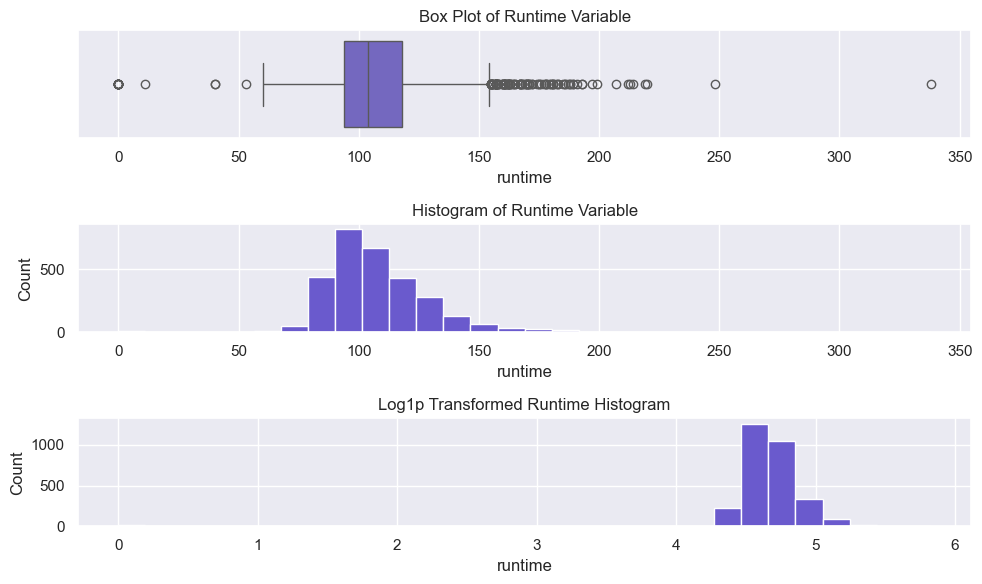

In [182]:
# Create a figure with 3 subplots to visualize the 'runtime' variable
f, ax = plt.subplots(3, figsize=(10, 6))  # 3 rows for plots with a specified figure size

# Set the overall figure size for the plots
sns.set(rc={'figure.figsize': (12, 8)})

# Box plot of the 'runtime' variable to show its distribution and identify any outliers
sns.boxplot(x=train.runtime, ax=ax[0], color='slateblue')
ax[0].set_title("Box Plot of Runtime Variable")

# Histogram of the 'runtime' variable to visualize the frequency distribution
sns.histplot(data=train, x='runtime', kde=False, ax=ax[1], color='slateblue', bins=30, alpha=1)
ax[1].set_title("Histogram of Runtime Variable")

# Histogram of the log1p transformed 'runtime' variable to visualize its distribution after transformation
sns.histplot(data=train, x=np.log1p(train.runtime), kde=False, ax=ax[2], color='slateblue', bins=30, alpha=1)
ax[2].set_title("Log1p Transformed Runtime Histogram")

# Adjust layout to prevent overlapping of titles and axes
f.tight_layout()

# Show the plots
plt.show()

The distribution of runtime appears reasonable, although there are several outliers on the right side of the plot. Applying a log transformation can help mitigate the impact of these outliers. However, one outlier in particular stands out, with a runtime close to 350 minutes. We will take a closer look at this specific outlier to understand its implications.

In [184]:
train.loc[train['runtime'].argmax(), ['title', 'runtime', 'revenue']]

title      Carlos
runtime     338.0
revenue    871279
Name: 1211, dtype: object

The movie with a runtime close to 350 minutes is titled *Carlos*, with a total duration of 338 minutes, which exceeds five and a half hours. This extraordinarily long runtime did not translate into box office success, making it an unhelpful data point for our model. Therefore, we will remove this entry from the dataset.

In [186]:
train = train.drop(train['runtime'].argmax())

In [187]:
print('Movies with runtime listed as 0: ',(train.runtime == 0).sum())

Movies with runtime listed as 0:  12


The dataset contains 12 movies with a runtime listed as 0, which is clearly erroneous since no film can have a true runtime of zero. To address this issue, we will replace these zero values with the median of the non-zero runtimes in the dataset.

In [189]:
# Calculate the median runtime of movies with a runtime greater than 0
median = train.loc[train['runtime'] > 0, 'runtime'].median()

# Replace zero runtimes in the training dataset with the calculated median
train["runtime_processed"] = train["runtime"].mask(train["runtime"] == 0, median)

# Replace zero runtimes in the testing dataset with the same median
test["runtime_processed"] = test["runtime"].mask(test["runtime"] == 0, median)

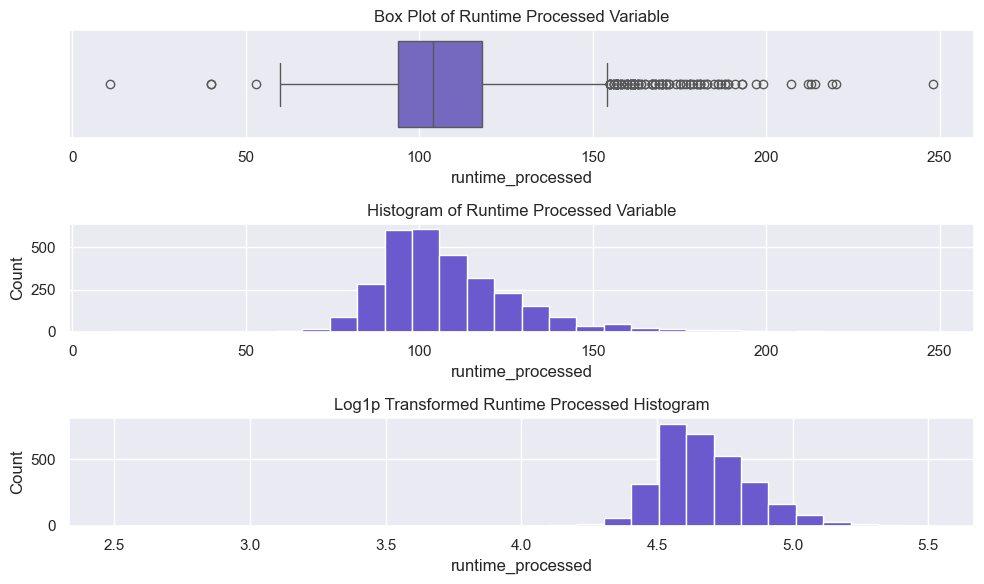

In [190]:
# Create a figure with 3 subplots to visualize the 'runtime_processed' variable
f, ax = plt.subplots(3, figsize=(10, 6))  # 3 rows for plots with a specified figure size

# Set the overall figure size for the plots
sns.set(rc={'figure.figsize': (12, 8)})

# Box plot of the 'runtime_processed' variable to show its distribution and identify any outliers
sns.boxplot(x=train.runtime_processed, ax=ax[0], color='slateblue')
ax[0].set_title("Box Plot of Runtime Processed Variable")

# Histogram of the 'runtime_processed' variable to visualize the frequency distribution
sns.histplot(data=train, x='runtime_processed', kde=False, ax=ax[1], color='slateblue', bins=30, alpha=1)
ax[1].set_title("Histogram of Runtime Processed Variable")

# Histogram of the log1p transformed 'runtime_processed' variable to visualize its distribution after transformation
sns.histplot(data=train, x=np.log1p(train.runtime_processed), kde=False, ax=ax[2], color='slateblue', bins=30, alpha=1)
ax[2].set_title("Log1p Transformed Runtime Processed Histogram")

# Adjust layout to prevent overlapping of titles and axes
f.tight_layout()

# Show the plots
plt.show()

The distribution of the processed runtime appears much cleaner now, particularly after the log transformation. This refined distribution will be significantly easier to work with in our analysis and modeling efforts.

### Bivariate Analysis

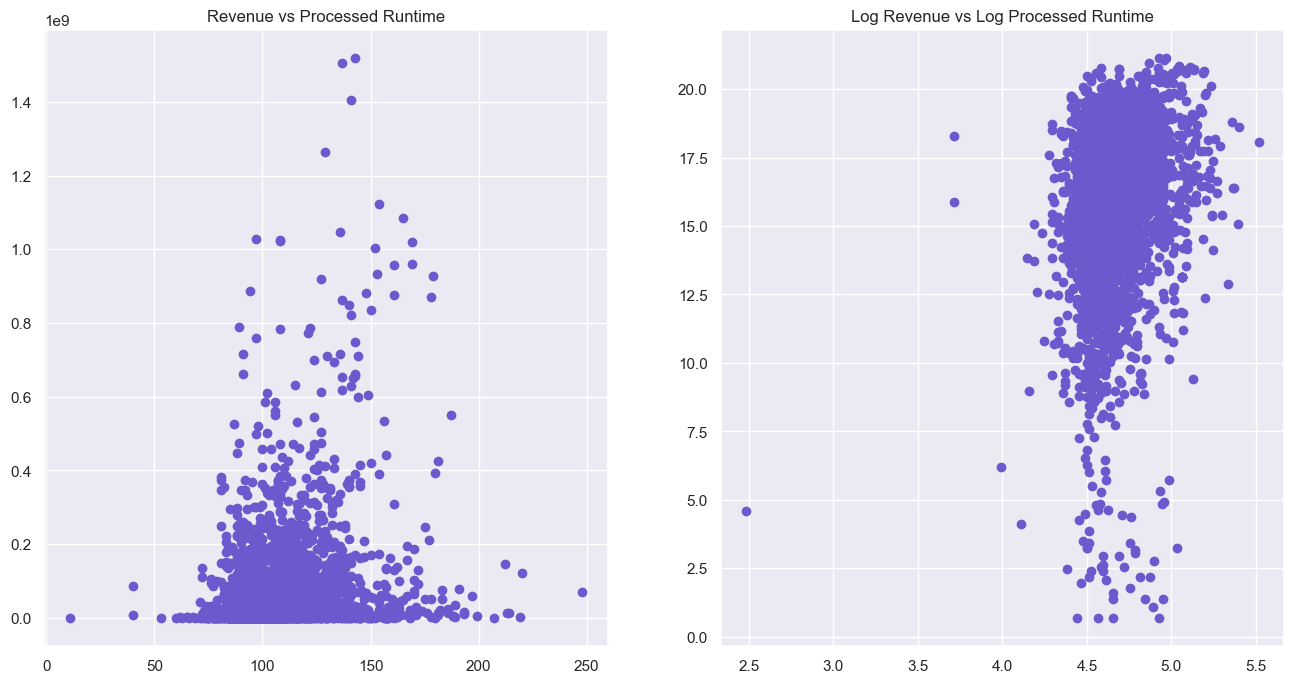

In [193]:
# Create a figure for the scatter plots with specified size
plt.figure(figsize=(16, 8))

# Subplot for Revenue vs. Processed Runtime
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.scatter(train['runtime_processed'], train['revenue'], color='slateblue')  # Scatter plot
plt.title('Revenue vs Processed Runtime')  # Title for the first subplot

# Subplot for Log Revenue vs. Log Processed Runtime
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.scatter(np.log1p(train['runtime_processed']), np.log1p(train['revenue']), color='slateblue')  # Scatter plot
plt.title('Log Revenue vs Log Processed Runtime')  # Title for the second subplot

# Show the plots
plt.show()

In [194]:
# Calculate Pearson's correlation between processed runtime and revenue
corr, _ = pearsonr(train['runtime_processed'], train['revenue'])
print('Pearson\'s correlation: %.3f' % corr)  # Print the correlation coefficient

# Calculate Pearson's correlation between log-transformed processed runtime and log-transformed revenue
corr, _ = pearsonr(np.log1p(train['runtime_processed']), np.log1p(train['revenue']))
print('Pearson\'s correlation: %.3f' % corr)  # Print the correlation coefficient for transformed values

Pearson's correlation: 0.226
Pearson's correlation: 0.227


We observe a small positive correlation between the runtime and revenue of a film, indicating that runtime may have a beneficial impact on box office performance. Therefore, it will be valuable to include this feature in our model.

In [196]:
log_features.append('runtime_processed')

### Additional Feature Engineering and Creation

Now we will revisit the budget and revenue columns. Both of these features contain numerous values that appear to be garbage data, which is critical to our model's success. Previously, we replaced these bad values with the median, but due to the high number of replacements needed, we require a more effective solution.

Instead, we will calculate the average budget and revenue for all studios associated with each film, as this is likely to provide a more accurate reflection of a movie's financials. The following functions will replace all budgets and revenues under $10,000 in our training set.

In [198]:
def getAvgStudioRev(movie):
    # Adjust the budget if it's less than $10,000
    if movie.budget < 10000: 
        if len(movie.production_companies_reform) > 0:
            studios = movie.production_companies_reform
            median_revs = []
            
            # Gather median revenue for all studios involved in the movie
            for studio in studios:
                if studio in companies_df.index:
                    median_revs.append(float(companies_df.loc[studio]['median_rev']))
            
            # If median revenue data is available and reasonable, use the average of these values
            if len(median_revs) > 0 and mean(median_revs) > 10000:
                movie.budget_processed = mean(median_revs)
            else:
                movie.budget_processed = train.budget.median()  # Default to median budget if no valid data
        else:
            movie.budget_processed = train.budget.median()
    
    # Adjust the revenue if it's less than $10,000
    if 'revenue' in movie and movie.revenue < 10000 and len(movie.production_companies_reform) > 0:
        studios = movie.production_companies_reform
        median_revs = []
        
        # Gather median revenue for all studios involved
        for studio in studios:
            if studio in companies_df.index:
                median_revs.append(float(companies_df.loc[studio]['median_rev']))
        
        # If valid median revenue data is available, update the revenue
        if len(median_revs) > 0 and mean(median_revs) > 10000:
            movie.revenue = mean(median_revs)
        else:
            movie.revenue = train.revenue.median()  # Default to median revenue if no valid data
        
    return movie

In [199]:
# Applying the getAvgStudioRev function to train and test datasets
train = train.apply(getAvgStudioRev, axis=1)
test = test.apply(getAvgStudioRev, axis=1)

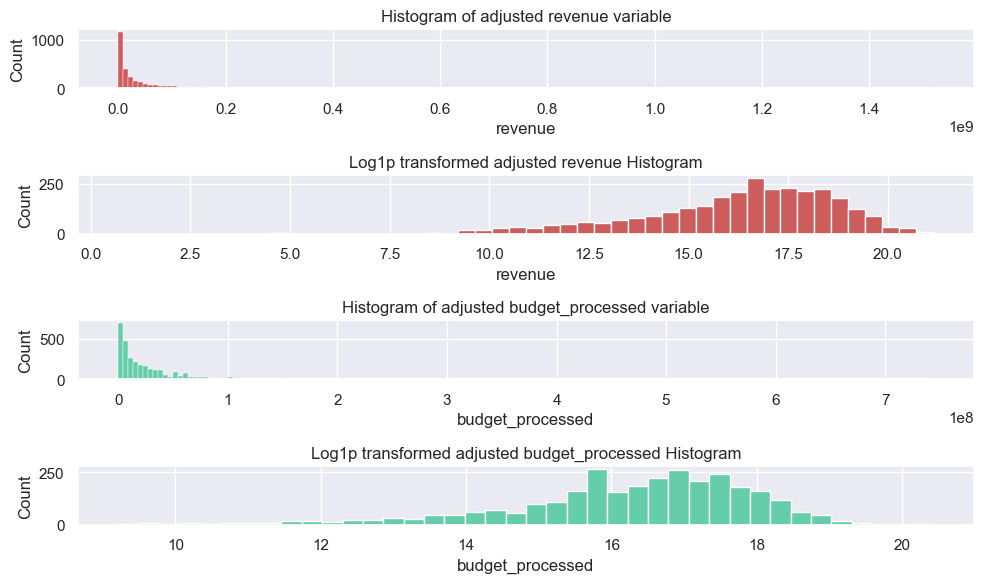

In [200]:
# Plot histograms for revenue and budget variables
f, ax = plt.subplots(4, figsize=(10, 6))

sns.set(rc={'figure.figsize': (12, 8)})

# Plot histogram of adjusted revenue variable
sns.histplot(x=train.revenue, kde=False, ax=ax[0], color='indianred', alpha=1)
ax[0].set_title("Histogram of adjusted revenue variable")

# Plot log1p transformed adjusted revenue histogram
sns.histplot(x=np.log1p(train.revenue), kde=False, ax=ax[1], color='indianred', alpha=1)
ax[1].set_title("Log1p transformed adjusted revenue Histogram")

# Plot histogram of adjusted budget_processed variable
sns.histplot(x=train.budget_processed, kde=False, ax=ax[2], color='mediumaquamarine', alpha=1)
ax[2].set_title("Histogram of adjusted budget_processed variable")

# Plot log1p transformed adjusted budget_processed histogram
sns.histplot(x=np.log1p(train.budget_processed), kde=False, ax=ax[3], color='mediumaquamarine', alpha=1)
ax[3].set_title("Log1p transformed adjusted budget_processed Histogram")

# Adjust the layout
f.tight_layout()

# Show the plot
plt.show()

After the adjustments, the distributions look much better. While there are still a number of lower values that may not be entirely accurate, we do not want to alter the values too drastically. Ideally, we would retrieve the true revenues and budgets, but for now, we will rely on the data provided.

Next, we need to account for how movies have changed over time and adjust for inflation, as our dataset includes movies dating back to the 1960s. To handle this, we will create two additional features:
1. **Budget-to-year ratio**: This will help adjust for the changes in production budgets over time.
2. **Runtime-to-year ratio**: This will capture how the average runtime of movies has evolved over the decades.

These two variables are expected to be the most useful, as both budget and runtime have likely seen the greatest amount of change over the past few decades of filmmking.


In [202]:
train['budget_to_year_ratio'] = train['budget_processed'] / (train['year'] * train['year'])
test['budget_to_year_ratio'] = test['budget_processed'] / (test['year'] * test['year'])

In [203]:
train['runtime_to_year_ratio'] = train['runtime'] / (train['year'])
test['runtime_to_year_ratio'] = test['runtime'] / (test['year'])

# Append to log features
log_features.append('budget_to_year_ratio')
log_features.append('runtime_to_year_ratio')

### Feature Selection
After thoroughly exploring the dataset and creating several new features for our model, it’s time to analyze the results and finalize the set of features to be included in the model. By selecting the most relevant features, we aim to improve the predictive performance while avoiding overfitting and reducing computational complexity. We will evaluate both the original and newly created features to determine their significance and relevance to our final model.


In [205]:
# Initial list of columns to drop
cols_to_drop = ['imdb_id', 'original_title', 'overview']

# List of additional columns to add
additional_cols = ['poster_path', 'status', 'popularity', 'production_countries', 'spoken_languages', 'tagline', 'title', 'Keywords', 'cast', 'crew']

# Use extend() to add multiple columns to cols_to_drop
cols_to_drop.extend(additional_cols)

# Check the updated list
print(cols_to_drop)

['imdb_id', 'original_title', 'overview', 'poster_path', 'status', 'popularity', 'production_countries', 'spoken_languages', 'tagline', 'title', 'Keywords', 'cast', 'crew']


### Dropping Unnecessary Columns

To streamline our dataset, we dropped columns that are either irrelevant or not useful for predictive modeling. These include:

- **imdb_id**: An identifier that doesn’t add predictive value.
- **original_title**: The movie’s title doesn’t provide numerical insight for predictions.
- **overview**: A textual description that’s difficult to quantify for model training.
- **poster_path**: A reference to an image, irrelevant for our analysis.
- **status**: Since all movies are released, this column adds no value.
- **tagline**: Creative marketing phrases, not indicative of a film’s success.
- **title**: Unique to each film and not useful for generalization in modeling.
- **production_countries**: Complex and not clearly linked to box office performance.
- **spoken_languages**: Not a strong predictor of revenue.
- **Keywords**: Too specific to each film to generalize.
- **cast** and **crew**: Require significant feature engineering and are unstructured for direct use.

These columns were dropped to focus on features that contribute more directly to revnue prediction.


In [207]:
print(train_features)

['belongs_to_collection', 'has_homepage', 'topStudio', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'mondayRelease', 'tuesdayRelease', 'wednesdayRelease', 'thursdayRelease', 'fridayRelease', 'saturdayRelease', 'sundayRelease', 'Winter', 'Fall', 'Spring', 'Summer']


These are the dummy variables that will be used in our model. Additionally, we need to apply log transformation to all of the numerical features to ensure better performance and handling of skewed data.

In [209]:
print(log_features)

['revenue', 'budget_processed', 'genre_rank', 'num_genres', 'numTopStudios', 'num_studios', 'studioRank', 'runtime_processed', 'budget_to_year_ratio', 'runtime_to_year_ratio']


We will log transform all of these features and include them in our set of features for the model.

In [211]:
for feat in log_features:
    if feat in train.columns:  # Check if the feature exists in the DataFrame
        train["log_" + feat] = np.log1p(train[feat])
        if feat != "revenue" and feat in test.columns:
            test["log_" + feat] = np.log1p(test[feat])
            train_features.append("log_" + feat)
    else:
        print(f"Warning: '{feat}' not found in train DataFrame.")

Now that we have created log-transformed features for all the desired variables, this will be our final list of features for the model. Let's take a look at the complete list.

In [213]:
# Print the list of training features and the number of features
print(train_features)
print()
print("Number of features: ", len(train_features))

['belongs_to_collection', 'has_homepage', 'topStudio', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', 'mondayRelease', 'tuesdayRelease', 'wednesdayRelease', 'thursdayRelease', 'fridayRelease', 'saturdayRelease', 'sundayRelease', 'Winter', 'Fall', 'Spring', 'Summer', 'log_budget_processed', 'log_genre_rank', 'log_num_genres', 'log_numTopStudios', 'log_num_studios', 'log_studioRank', 'log_runtime_processed', 'log_budget_to_year_ratio', 'log_runtime_to_year_ratio']

Number of features:  29


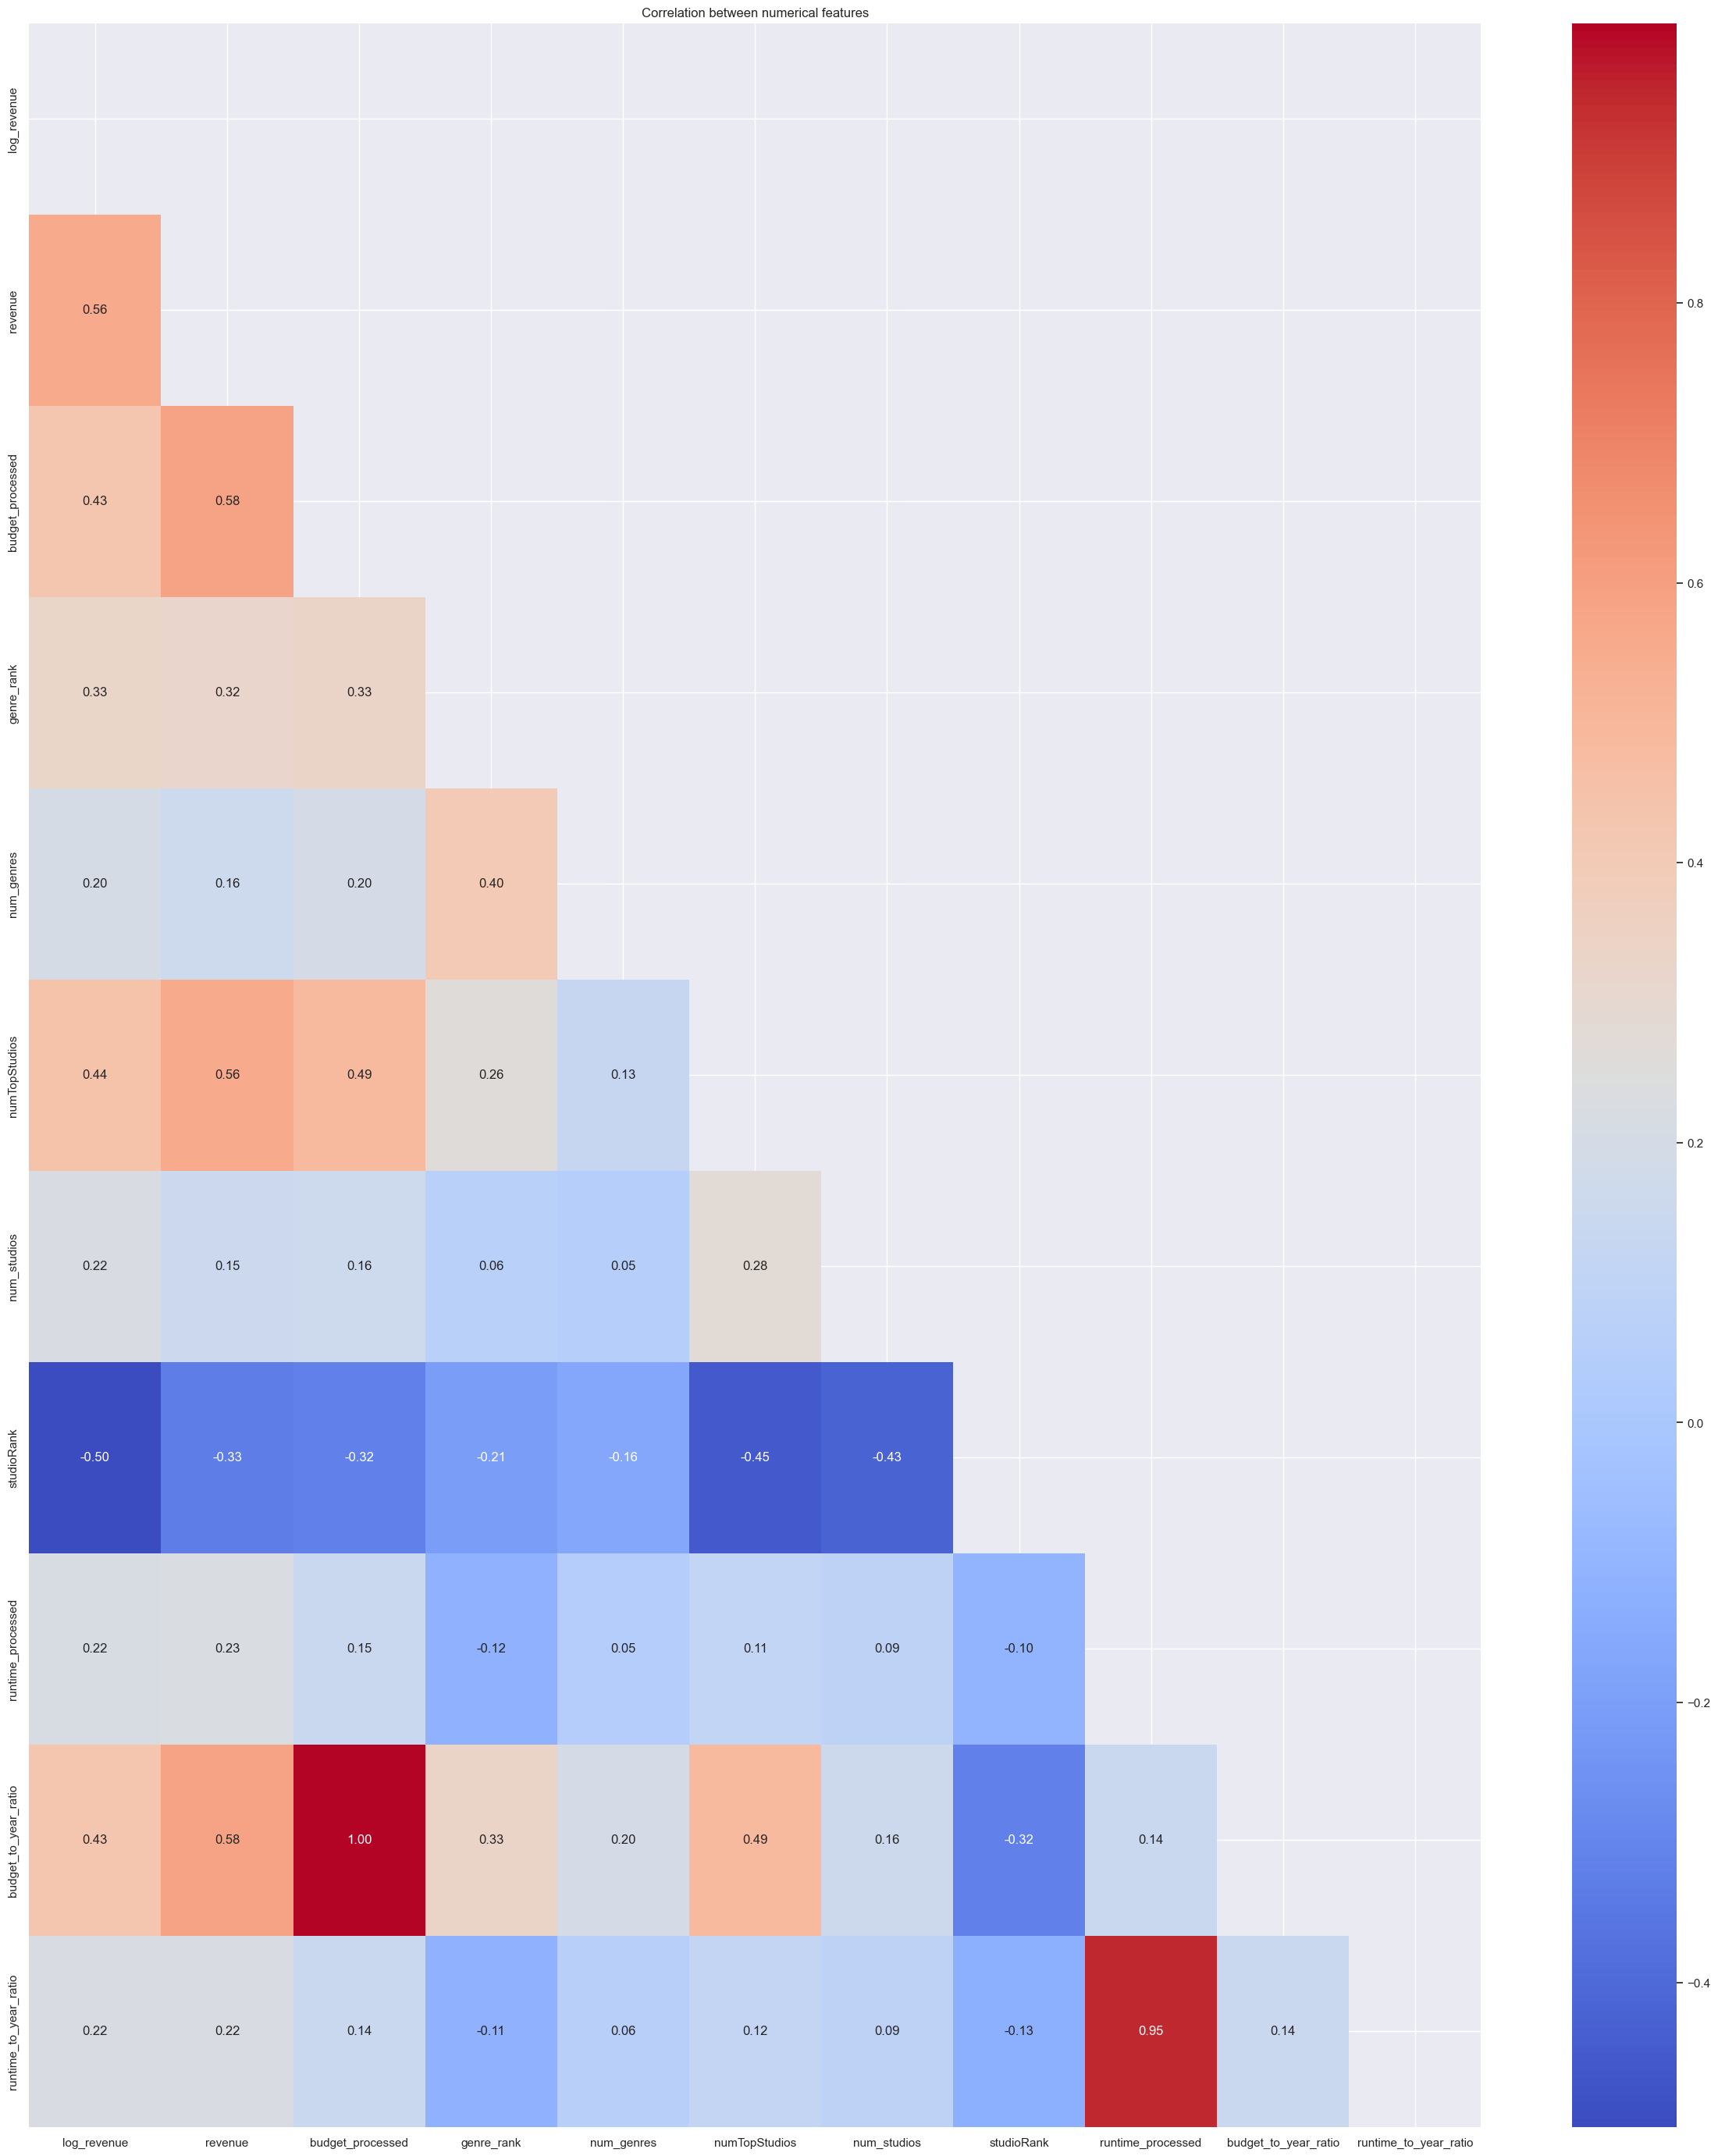

In [214]:
# Correlation matrix for numerical features
sns.set(rc={'figure.figsize':(30,35)})

# Compute the correlation matrix
corr = train[['log_revenue', *log_features]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot the heatmap
sns.heatmap(corr, mask=mask, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm')

plt.title("Correlation between numerical features")
plt.show()

The correlation matrix reveals valuable insights into the relationships between our variables. The leftmost column shows that **budget** is highly correlated with **revenue**, affirming that budget is a critical factor in predicting revenue. However, the matrix also indicates some degree of multicollinearity, particularly between features like **num_genres** and **num_top_studios**, and **runtime_to_year_ratio**, which complicates linear regression modeling. As a result, **Random Forest** and **LightGBM**, are preferable due to their resilience to correlated features.


### Main Approach 

### Models & Algorithms
We chose **LightGBM** and **Random Forest** for predicting movie revenue because they handle large datasets well and are powerful in predicting numerical outputs like revenue. These models learn from important features such as budget, release date, and runtime, and output predicted movie revenues. Since **budget** shows a strong positive correlation with revenue, it plays a key role in the model's predictions. Additionally, both models are robust against multicollinearity, which we observed in our correlation analysis.

### Hyperparameter Tuning Using RandomizedSearchCV
We selected **RandomizedSearchCV** for hyperparameter tuning due to its efficiency. Rather than evaluating every possible hyperparameter combination, it randomly samples a subset of combinations, speeding up the tuning process while still finding effective parameters.

The **RandomizedSearchCV** algorithm optimizes model accuracy by adjusting key hyperparameters such as the number of trees, tree depth, and regularization factors. This process improves model performance by ensuring the model can make accurate predictions using the input features, while avoiding overfitting. The use of this approach allows us to effectively fine-tune our models for optimal results.

### Modeling

Now that we have our final list of features, we can start modeling. We will begin by setting up our `X` and `y`, followed by creating a train/test split on our data. The data will be split into 80% for training and 20% for testing (as a validation set).

In [220]:
# Set up X and y for modeling
X = train[train_features]
y = train['log_revenue']

# Create an 80/20 stratified split of the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

# Ensure the dimensions are correct
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (2399, 29) (2399,)
Test set: (600, 29) (600,)


Next, we will define a few helper functions for efficiency and organization. The first function will perform a grid search for hyperparameter tuning on each of our models. The second function will evaluate and compare our baseline model to the tuned model, showing us the percent difference. Lastly, the third function will output several key metrics to judge the performance of our models.

### Evaluation Metrics

For evaluating the success of our model, we use a combination of quantitative and qualitative metrics:

- **Mean Squared Error (MSE)**: Calculates the average squared differences between the predicted and actual values.
- **Root Mean Squared Error (RMSE)**: Interprets the error in the same unit as the target variable.
- **Mean Absolute Error (MAE)**: Measures the average absolute differences between predictions and actual results.
- **Mean Absolute Percentage Error (MAPE)**: Indicates the percentage of error in the predictions.
- **Accuracy**: Based on MAPE, representing how well the model predicts revenue.

In [223]:
def evaluate(model, test_features, test_labels):
    # Make predictions on the test set
    predictions = model.predict(test_features)
    
    # Calculate absolute errors
    errors = abs(predictions - test_labels)
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = 100 * np.mean(errors / test_labels)
    
    # Calculate accuracy as 100 - MAPE
    accuracy = 100 - mape
    
    # Print the results
    print('Average Error: {:0.4f}'.format(np.mean(errors)))
    print('Accuracy = {:0.3f}%'.format(accuracy))
    
    return accuracy

In [224]:
def metrics(y_pred, y_test):
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    # Calculate Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)
    
    # Calculate Mean Absolute Error (MAE)
    errors = abs(y_pred - y_test)
    mae = np.mean(errors)
    
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = 100 * (errors / y_test)
    
    # Print the metrics
    print('Mean Squared Error: ', round(mse, 4))
    print('Root Mean Squared Error: ', round(rmse, 4))
    print('Mean Absolute Error: ', round(mae, 4))
    
    # Calculate and display accuracy based on MAPE
    test_accuracy = 100 - np.mean(mape)
    print('Test Set Accuracy (from Mean Absolute Percentage Error): {:.3f}%'.format(test_accuracy))

### Random Forest Model

We will start with the **Random Forest** algorithm, an ensemble learning method that constructs multiple decision trees during training. Each tree makes its own prediction, and the final prediction is determined by averaging the outputs of all the individual trees. This approach improves accuracy and reduces errors that may occur when relying on a single decision tree, as it helps mitigate overfitting and captures a broader range of data patterns.

### Baseline

In [227]:
rfr_base_model = RandomForestRegressor(random_state=42)
rfr_base_model.fit(X_train, y_train.values.ravel())

RandomForestRegressor(random_state=42)

In [228]:
y_pred = rfr_base_model.predict(X_test)

In [229]:
errors = abs(np.expm1(y_pred) - np.expm1(y_test.values))
# Print out the mean absolute error (MAE)
print('Average Error:', round(np.mean(errors), 2))

Average Error: 36007456.25


In [230]:
print('Random Forest Baseline Model Metrics:')
metrics(y_pred, y_test.values)

Random Forest Baseline Model Metrics:
Mean Squared Error:  2.7139
Root Mean Squared Error:  1.6474
Mean Absolute Error:  1.1358
Test Set Accuracy (from Mean Absolute Percentage Error): 91.222%


### Grid Search Hyperparameter Tuning

We use Grid Search to find the optimal hyperparameter combination that maximizes model performance.

In [232]:
# Initialize and train the base model for Random Forest
rfr_base_model = RandomForestRegressor(random_state=42)
rfr_base_model.fit(X_train, y_train.values.ravel())

# Create the parameter grid for RandomizedSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 25, 30],
    'max_features': [0.4, 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 3, 5],
    'n_estimators': [100, 400]
}

# Initialize RandomizedSearchCV
random_search_rfr = RandomizedSearchCV(rfr_base_model, param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the random search model
random_search_rfr.fit(X_train, y_train.values.ravel())

# Retrieve the best model found by RandomizedSearchCV
rfr_best_model = random_search_rfr.best_estimator_

# Evaluate the base model
print('Base Model:')
base_predictions = rfr_base_model.predict(X_test)
base_average_error = np.mean(np.abs(base_predictions - y_test.values))  # Calculate average error
base_accuracy = evaluate(rfr_base_model, X_test, y_test.values)

print()

print('Model after Tuning:')
# Evaluate the best model
best_predictions = rfr_best_model.predict(X_test)
best_average_error = np.mean(np.abs(best_predictions - y_test.values))  # Calculate average error
best_accuracy = evaluate(rfr_best_model, X_test, y_test.values)

# Calculate and print the improvement
improvement = 100 * (best_accuracy - base_accuracy) / base_accuracy
print('Improvement of {:.2f}%.'.format(improvement))

Base Model:
Average Error: 1.1358
Accuracy = 91.222%

Model after Tuning:
Average Error: 1.1264
Accuracy = 91.231%
Improvement of 0.01%.


In [233]:
y_pred = rfr_best_model.predict(X_test)
print('Random Forest Model (After Tuning) Metrics:')
metrics(y_pred, y_test.values)

Random Forest Model (After Tuning) Metrics:
Mean Squared Error:  2.6926
Root Mean Squared Error:  1.6409
Mean Absolute Error:  1.1264
Test Set Accuracy (from Mean Absolute Percentage Error): 91.231%


### Feature Importances

We achieved promising accuracy with our initial model, which is encouraging. Now, we will examine the importance of each feature in our Random Forest model to gain insights into which factors contributed most significantly to the predictions.

In [236]:
# Retrieve feature importances from the best Random Forest model
feature_importances = rfr_best_model.feature_importances_

# Get the indices of features sorted by importance in descending order
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Loop through the top 20 features and print their rankings
for f in range(20):
    # Display the feature number, feature name, and its importance score
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_budget_to_year_ratio (0.205696)
2. log_budget_processed (0.197429)
3. log_studioRank (0.089667)
4. log_runtime_to_year_ratio (0.064379)
5. log_num_studios (0.059067)
6. log_runtime_processed (0.057335)
7. log_genre_rank (0.056650)
8. topStudio (0.054363)
9. log_numTopStudios (0.052741)
10. belongs_to_collection (0.027785)
11. log_num_genres (0.020864)
12. has_homepage (0.012818)
13. 2010s (0.009819)
14. mondayRelease (0.008680)
15. fridayRelease (0.007468)
16. Fall (0.007189)
17. Spring (0.007084)
18. 2000s (0.006667)
19. Summer (0.006448)
20. thursdayRelease (0.006253)


<Axes: >

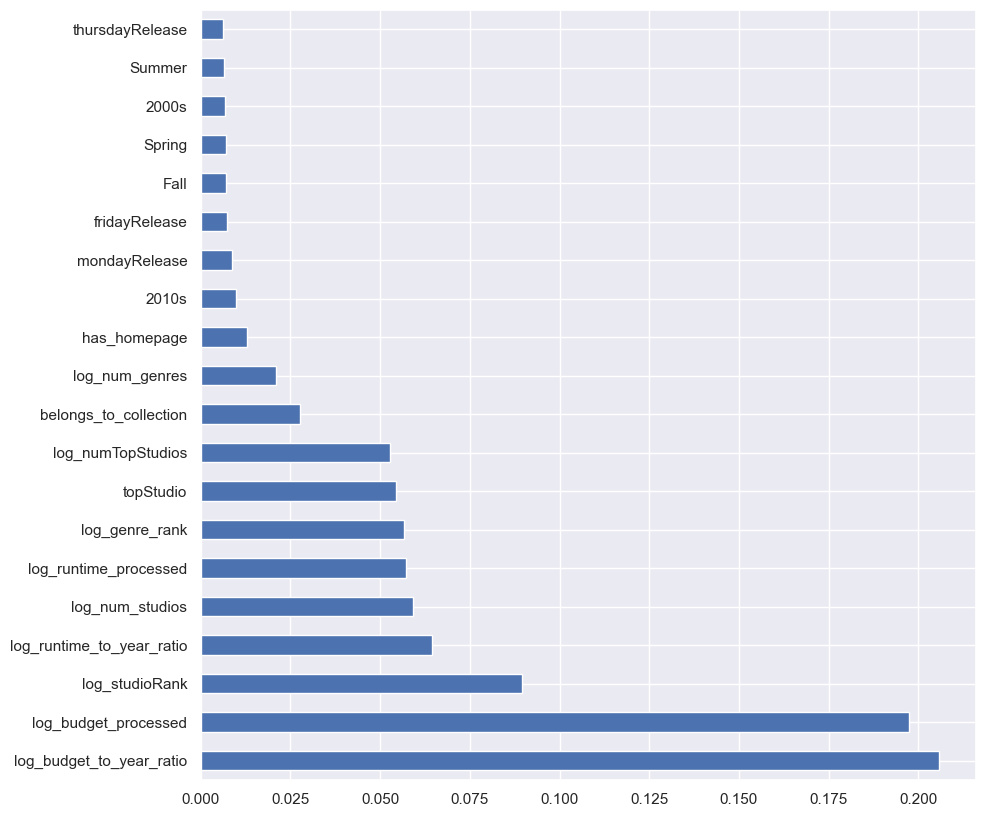

In [237]:
# Create a Pandas Series for feature importances using the feature names from X_train
feat_importances = pd.Series(feature_importances, index=X.columns)

# Plot the top 20 most important features as a horizontal bar plot
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

In this feature importance plot, we observe that the budget-related features, specifically the **log_budget_processed** and **log_budget_to_year_ratio**, are the most influential in predicting revenue. Other significant features include **log_studioRank** and **topStudio**, which further indicate the importance of the movie’s production quality and distribution strength. Additionally, **belongs_to_collection** and **log_runtime_processed** show considerable impact, reflecting the value of franchise films and movie length. These results reinforce that well-budgeted, well-promoted films tend to perform better in revenue predictions.

### LightGBM
**LightGBM**, a gradient boosting framework similar to XGBoost but designed for improved speed and efficiency. LightGBM is lightweight, consumes less memory, and is particularly effective for large-scale datasets. Let's evaluate its performance on our data.

### Baseline

In [241]:
lgbm_base_model = LGBMRegressor(random_state=42)
lgbm_base_model.fit(X_train, y_train.values.ravel())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1276
[LightGBM] [Info] Number of data points in the train set: 2399, number of used features: 28
[LightGBM] [Info] Start training from score 16.199708


LGBMRegressor(random_state=42)

In [242]:
y_pred = lgbm_base_model.predict(X_test)

In [243]:
print('LightGBM Baseline Model Metrics:')
metrics(y_pred, y_test.values)

LightGBM Baseline Model Metrics:
Mean Squared Error:  2.6744
Root Mean Squared Error:  1.6354
Mean Absolute Error:  1.1347
Test Set Accuracy (from Mean Absolute Percentage Error): 91.270%


### Grid Search Hyperparameter Tuning

We use Grid Search to find the optimal hyperparameter combination that maximizes model performance.

In [245]:
# Initialize a basic LGBMRegressor model with verbose=-1 to suppress warnings
lgbm_base_model = LGBMRegressor(verbose=-1)

# Train the base model using the training data
lgbm_base_model.fit(X_train, y_train.values.ravel())

# Continue with your RandomizedSearchCV process as usual
# Create the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'colsample_bytree': [0.8, 1.0],
    'max_depth': [5, 10, 15],
    'reg_alpha': [0.1, 0.3, 0.5],
    'reg_lambda': [0.1, 0.3, 0.5],
    'subsample': [0.8, 0.9],
    'num_leaves': [31, 63],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(lgbm_base_model, param_grid, n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42)

# Fit the random search model
random_search.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=5, estimator=LGBMRegressor(verbose=-1),
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'max_depth': [5, 10, 15],
                                        'n_estimators': [100, 200],
                                        'num_leaves': [31, 63],
                                        'reg_alpha': [0.1, 0.3, 0.5],
                                        'reg_lambda': [0.1, 0.3, 0.5],
                                        'subsample': [0.8, 0.9]},
                   random_state=42, scoring='neg_mean_squared_error')

In [246]:
print('Base Model:')
# Evaluate the base model
base_predictions = lgbm_base_model.predict(X_test)
base_average_error = np.mean(np.abs(base_predictions - y_test.values))  # Calculate average error
base_accuracy = evaluate(lgbm_base_model, X_test, y_test.values)

# Retrieve the best model found by RandomizedSearchCV
lgbm_best_model = random_search.best_estimator_

print()
print('Model after Tuning:')
# Evaluate the best model
best_predictions = lgbm_best_model.predict(X_test)
best_average_error = np.mean(np.abs(best_predictions - y_test.values))  # Calculate average error
best_accuracy = evaluate(lgbm_best_model, X_test, y_test.values)

# Calculate and print the improvement
improvement = 100 * (best_accuracy - base_accuracy) / base_accuracy
print('Improvement of {:0.2f}%.'.format(improvement))

Base Model:
Average Error: 1.1347
Accuracy = 91.270%

Model after Tuning:
Average Error: 1.1258
Accuracy = 91.349%
Improvement of 0.09%.


In [247]:
# Use the best LightGBM model (after hyperparameter tuning) to make predictions on the test set
y_pred = lgbm_best_model.predict(X_test)

# Print the evaluation metrics for the LightGBM model after tuning
print('LightGBM Model (After Tuning) Metrics:')

# Call the metrics function to evaluate the predictions and compare them with the true values
metrics(y_pred, y_test.values)

LightGBM Model (After Tuning) Metrics:
Mean Squared Error:  2.643
Root Mean Squared Error:  1.6257
Mean Absolute Error:  1.1258
Test Set Accuracy (from Mean Absolute Percentage Error): 91.349%


This is our best accuracy so far! Even the baseline model performed excellently, and while tuning didn't result in a significant improvement, the results are still impressive. Now, let's examine which features had the greatest impact on our model.

### Feature Importances

In [250]:
feature_importances = lgbm_best_model.feature_importances_
indices = np.argsort(feature_importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(20):
    print("%d. %s (%f)" % (f + 1, X_train.columns[indices[f]], feature_importances[indices[f]]))

Feature ranking:
1. log_budget_processed (231.000000)
2. log_runtime_to_year_ratio (220.000000)
3. log_genre_rank (216.000000)
4. log_studioRank (203.000000)
5. log_budget_to_year_ratio (162.000000)
6. log_runtime_processed (161.000000)
7. log_num_studios (109.000000)
8. log_num_genres (59.000000)
9. belongs_to_collection (56.000000)
10. log_numTopStudios (43.000000)
11. has_homepage (36.000000)
12. topStudio (36.000000)
13. 2000s (30.000000)
14. fridayRelease (28.000000)
15. 2010s (25.000000)
16. Fall (22.000000)
17. 1970s (20.000000)
18. mondayRelease (18.000000)
19. Summer (16.000000)
20. 1990s (15.000000)


<Axes: >

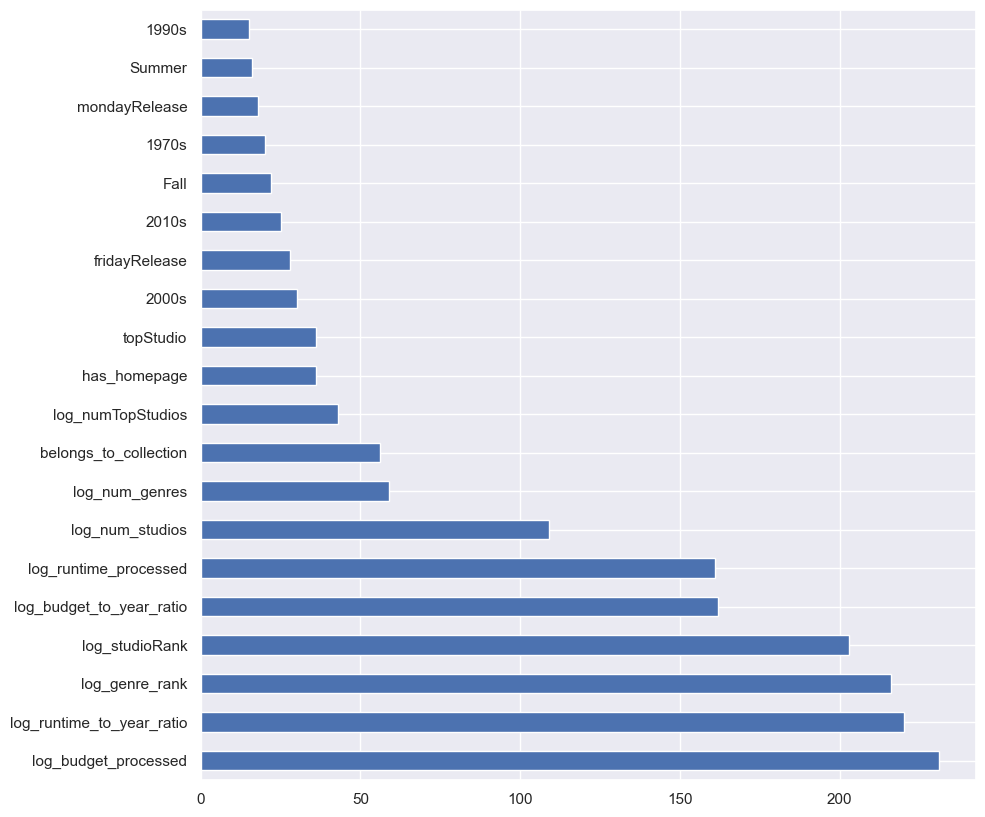

In [251]:
feat_importances = pd.Series(feature_importances, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=[10,10])

In this feature importance plot, we notice that budget-related features, specifically **log_budget_processed** and **log_budget_to_year_ratio**, remain highly influential. However, we now see **log_runtime_processed** and **log_runtime_to_year_ratio** rising in significance, reflecting how film length may also play a role in revenue predictions. Additionally, engineered features like **log_num_studios** and **log_genre_rank** make an appearance among the top features, confirming the impact of our feature creation efforts. This shift highlights the dynamic nature of feature importance as we explore different models.


In [253]:
# Calculate and print the average error of the LightGBM model after converting predictions back from log1p scale
print('Average error of LightGBM: ${:.2f}'.format(
    np.mean(abs(np.expm1(lgbm_best_model.predict(X_test)) - np.expm1(y_test.values)))
))

# Calculate and print the average error of the Random Forest model after converting predictions back from log1p scale
print('Average error of Random Forest: ${:.2f}'.format(
    np.mean(abs(np.expm1(rfr_best_model.predict(X_test)) - np.expm1(y_test.values)))
))

Average error of LightGBM: $37311452.69
Average error of Random Forest: $37865548.98


### Results & Analysis
Our best model was **LightGBM**, achieving an RMSE of 1.6257 and an accuracy of 91.34% based on the mean absolute percentage error. **Random Forest** closely followed with an RMSE of 1.6409 and accuracy of 91.23%. Both models, along with the others, achieved over 90% accuracy, which is highly encouraging. Despite the high percentages, the **average error** helps distinguish the models, with **LightGBM** showing slightly better results after tuning compared to **Random Forest** in terms of both accuracy and error. The difference in performance highlights the effectiveness of gradient boosting techniques, particularly LightGBM, for tasks like movie box office revenue prediction.

With our two models, converting the log-transformed revenue back to actual values, we observe average errors of 37.31 million for LightGBM and 37.87 million for Random Forest. While these errors seem high, they are relatively minor for blockbuster hits grossing over 600 million, where a 35 million deviation is acceptable. However, for smaller movies grossing around \$40 million, such errors become significant. Despite these challenges, given the complexity of the movie industry and our dataset limitations, we are satisfied with the predictive performance of our models.

### Limitations and Potential Improvements

In our project, several limitations impacted the results. First, the dataset provided only 3000 data points with revenue, while many more were withheld for the competition. A larger dataset could significantly improve model accuracy. Moreover, data inconsistencies, particularly in the budget and revenue columns, presented challenges, with many values either zero or unreasonably low. Better data quality would undoubtedly improve predictions.

In terms of feature engineering, we filled missing budget values using the average from other movies by the same studio. While this was effective, a regression model for missing values could yield more accurate results. Some columns, like title, overview, and keywords, were also underutilized, as text-based analysis or sentiment analysis could provide more insights. Using more advanced techniques, such as neural networks for image recognition of posters, was beyond the scope of this project but could be an interesting future addition.

Finally, while we made informed decisions regarding models and hyperparameter tuning, there is always room for improvement. With more experience, we might explore better modeling approaches or tuning methods to optimize model performance further.

### Future Work

In [395]:
from sklearn.linear_model import LinearRegression

# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the Linear Regression model using the training data
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model using the evaluate and metrics functions
print("Linear Regression Model Performance:")
lr_accuracy = evaluate(lr_model, X_test, y_test)

print("\nDetailed Metrics for Linear Regression Model:")
metrics(y_pred, y_test)

Linear Regression Model Performance:
Average Error: 1.1985
Accuracy = 90.564%

Detailed Metrics for Linear Regression Model:
Mean Squared Error:  3.0537
Root Mean Squared Error:  1.7475
Mean Absolute Error:  1.1985
Test Set Accuracy (from Mean Absolute Percentage Error): 90.564%


We initially tried using **Linear Regression**, which resulted in a lower accuracy of **90.564%**. If we had more time, we could enhance it by addressing challenges such as the complexity of feature interactions, multicollinearity, and outliers. The feature importance plot shows that **budget-related features** like *log_budget_processed* and *log_budget_to_year_ratio* are the most influential, alongside **studio rank** and **movie length**. Managing these by using more robust feature engineering and outlier handling could significantly improve predictions, particularly for less well-budgeted films.